In [11]:
### autoreload
%reload_ext autoreload
%autoreload 2

### imports
# general
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
# plotting
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
from matplotlib.patches import Patch

# custom
from calcification import analysis, utils, plotting, config, processing

# Bioerosion: end-to-end

In [12]:
### process raw data
carbonate_df = processing.populate_carbonate_chemistry(
    fp=config.data_dir / 'Orlando_data.xlsx',
    sheet_name='bioerosion',
    selection_dict={'include': 'yes'})
print(f"\nShape of dataframe with all rows marked for inclusion: {carbonate_df.shape}")

Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml
Loading measured values...


Calculating carbonate chemistry:   0%|          | 0/83 [00:00<?, ?it/s]


Shape of dataframe with all rows marked for inclusion: (83, 82)


In [13]:
### basic processing to get ready for assigning effect sizes
# assign treatment groups
carbonate_df_tgs = processing.assign_treatment_groups_multilevel(carbonate_df)
print(f"\nShape of dataframe with treatment groups: {carbonate_df_tgs.shape}")
n1_rows = len(carbonate_df_tgs[carbonate_df_tgs['n'] == 1])
# grouping any samples with samples of n=1
carbonate_df_tgs_no_ones = processing.aggregate_treatments_rows_with_individual_samples(carbonate_df_tgs)
print(f"\nShape of dataframe with treatment groups and grouped n=1 rows: {carbonate_df_tgs_no_ones.shape}. \nOriginal had {n1_rows} n=1 rows.")
# remove rows which have nans in both calcification_sd and calcification_se
carbonate_df_tgs_no_ones = carbonate_df_tgs_no_ones.dropna(subset=['calcification_sd', 'calcification_se'], how='all')
working_df = carbonate_df_tgs_no_ones.copy()

Assigning treatment groups:   0%|          | 0/18 [00:00<?, ?it/s]


Shape of dataframe with treatment groups: (83, 87)

Shape of dataframe with treatment groups and grouped n=1 rows: (83, 87). 
Original had 0 n=1 rows.


In [14]:
### data summary
# number of studies
print(f'Number of studies: {len(working_df["original_doi"].unique())}')
# number of distinct locations
print(f'Number of distinct named locations: {len(working_df["location"].unique())}')
print(f'Number of distinct locations (by coordinate pair): {working_df.groupby(['latitude', 'longitude']).ngroups}')
print(f'Number of visits to a unique location (e.g. including times when studies have used the same location): {working_df.doi.nunique()}')

check_waiting_df = pd.read_excel(
    config.data_dir / 'Orlando_data.xlsx',
    sheet_name='bioerosion',
)

# filter first, then group and count
filtered = check_waiting_df[check_waiting_df['Include'].isin(['revisit', 'check'])]
count_per_doi = filtered.groupby('DOI').size()
print(f'Number of studies marked as "revisit" or "check": {len(count_per_doi)} corresponding to {len(filtered)} rows.')
# for bioerosion, assign taxa values to core_grouping column
working_df['core_grouping'] = working_df['taxa'] 

Number of studies: 13
Number of distinct named locations: 12
Number of distinct locations (by coordinate pair): 9
Number of visits to a unique location (e.g. including times when studies have used the same location): 16
Number of studies marked as "revisit" or "check": 1 corresponding to 8 rows.


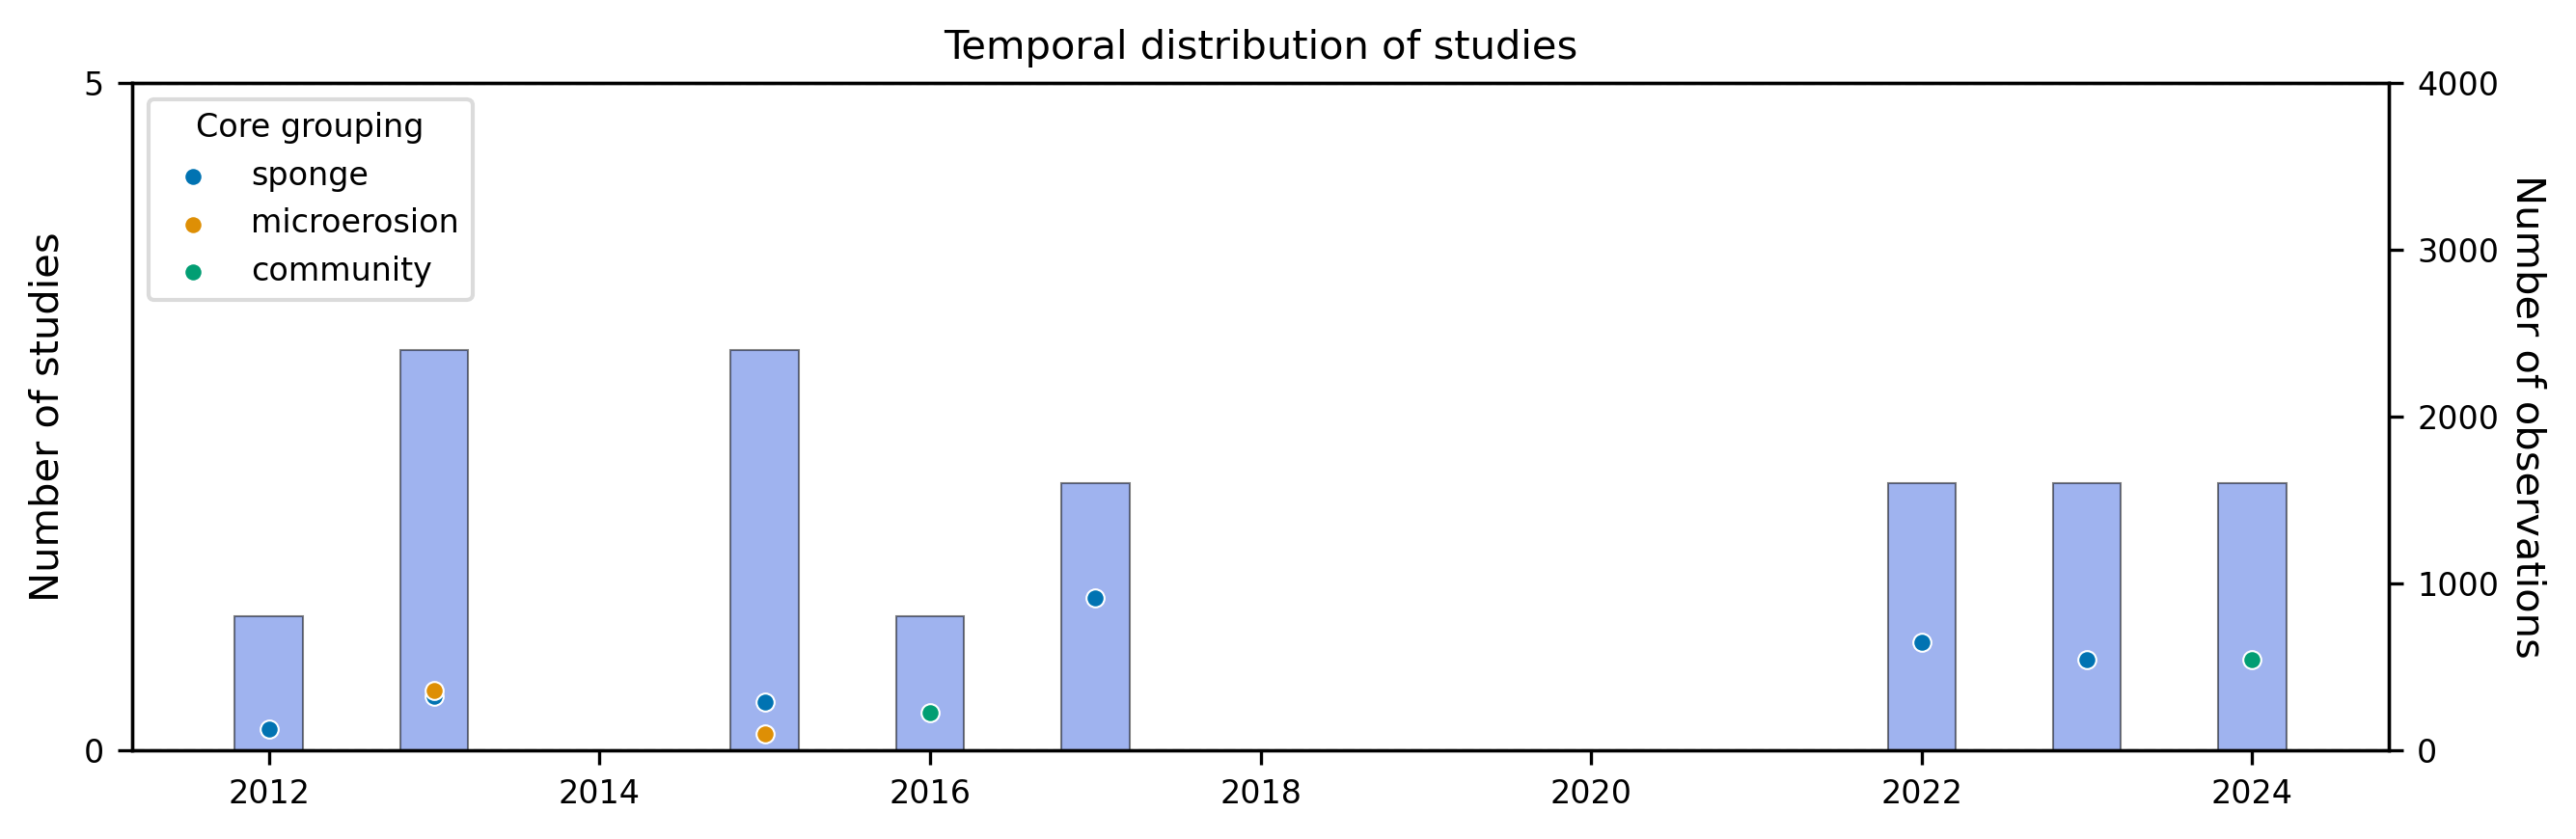

In [15]:
### plot temporal distribution of studies, broken down by species
plotting.plot_study_timeseries(working_df, colorby='core_grouping');

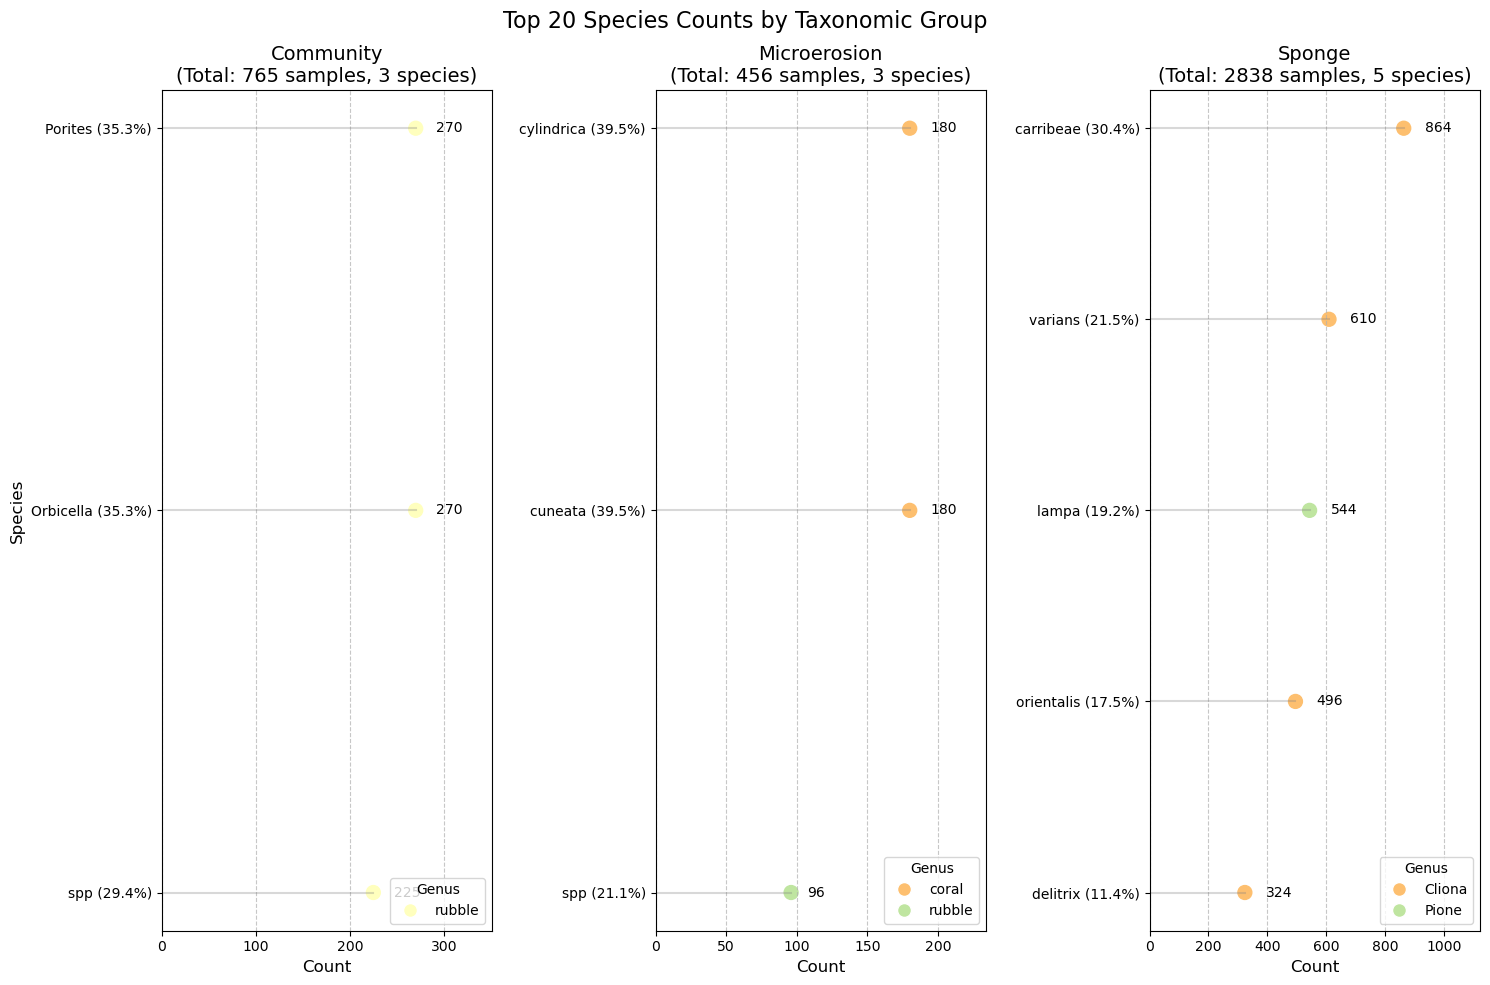

In [16]:
### plot taxonomic distribution of study organisms (
plotting.create_faceted_dotplot_with_percentages(working_df, top_n=20);

## Units

Number of different calcification units: 4


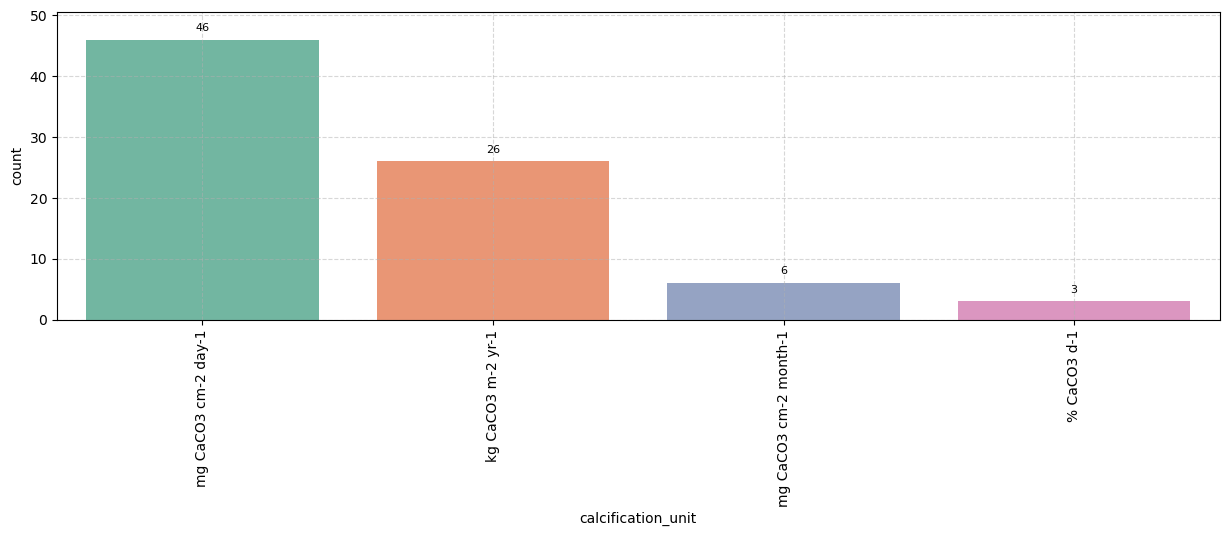

In [17]:
### raw units
plt.figure(figsize=(15, 4))
count_order = working_df['calcification_unit'].value_counts().index # sort by number of counts for each calcification unit
sns.countplot(data=working_df, x='calcification_unit', order=count_order, palette='Set2', hue='calcification_unit')
plt.xticks(rotation=90)
plt.grid(ls='--', alpha=0.5)
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
plt.ylim(0, working_df['calcification_unit'].value_counts().max() * 1.1)

print(f'Number of different calcification units: {len(working_df["calcification_unit"].unique())}')

Number of distinct types of calcification measurement: 2


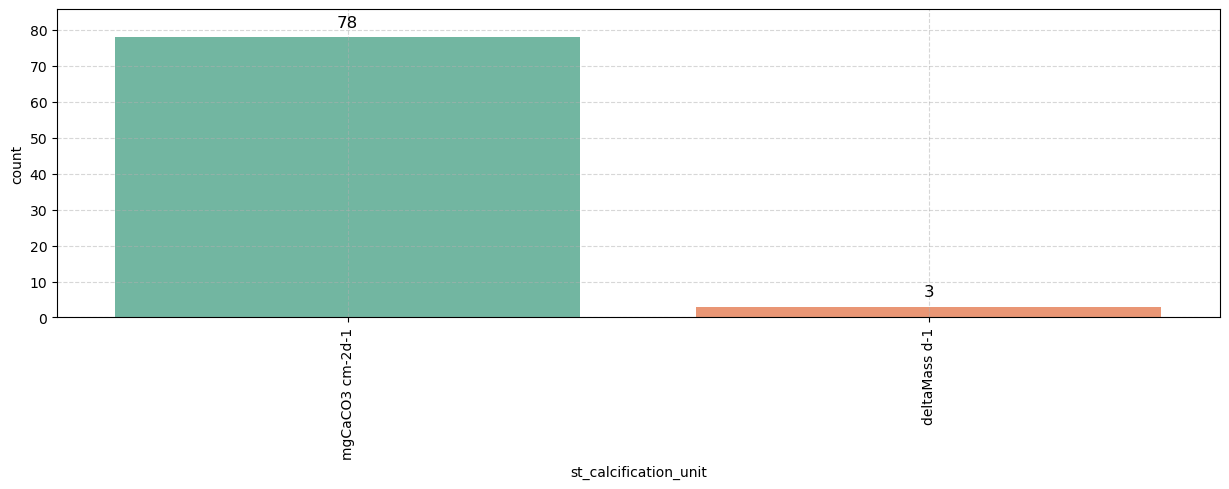

In [18]:
### standardised units
plt.figure(figsize=(15, 4))
count_order = working_df['st_calcification_unit'].value_counts().index # sort by number of counts for each calcification unit
sns.countplot(data=working_df, x='st_calcification_unit', order=count_order, palette='Set2', hue='st_calcification_unit')
plt.xticks(rotation=90);
plt.grid(ls='--', alpha=0.5)
# plot numbers at the top of the bars
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
plt.ylim(0, working_df['st_calcification_unit'].value_counts().max() * 1.1)
    
print(f'Number of distinct types of calcification measurement: {len(working_df["st_calcification_unit"].unique())}')

Number of distinct types of calcification measurement: 2


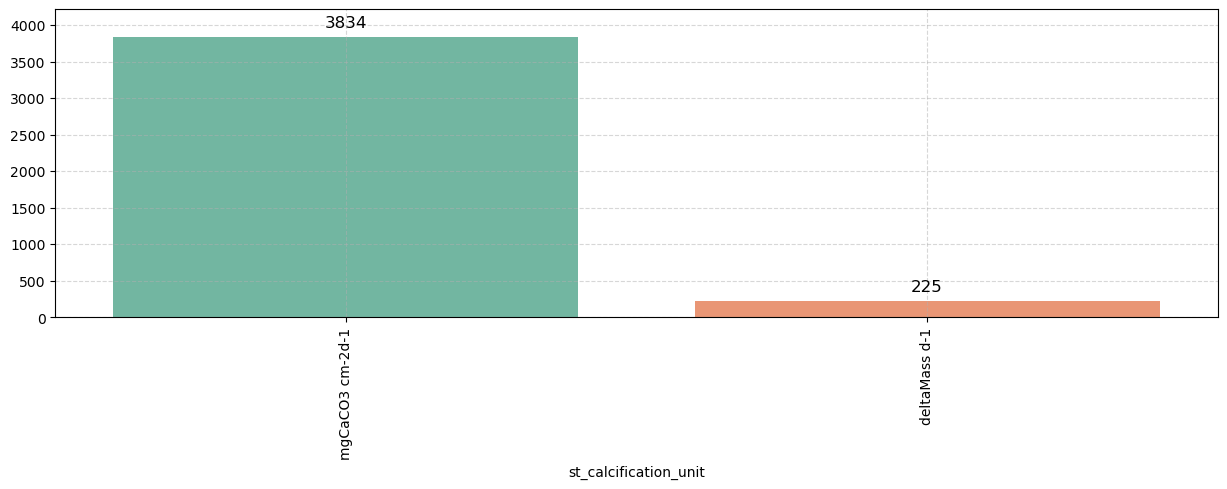

In [19]:
### standardised units with total samples (n)
plt.figure(figsize=(15, 4))

# Group by 'st_calcification_unit' and sum the 'n' column
unit_counts = working_df.groupby('st_calcification_unit')['n'].sum().sort_values(ascending=False)

# Plot the data
sns.barplot(x=unit_counts.index, y=unit_counts.values, palette='Set2', hue=unit_counts.index)
plt.xticks(rotation=90)
plt.grid(ls='--', alpha=0.5)

# Annotate the bars with the total counts
for i, value in enumerate(unit_counts.values):
    plt.annotate(f'{int(value)}', (i, value), ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
plt.ylim(0, unit_counts.max() * 1.1)

print(f'Number of distinct types of calcification measurement: {len(unit_counts)}')

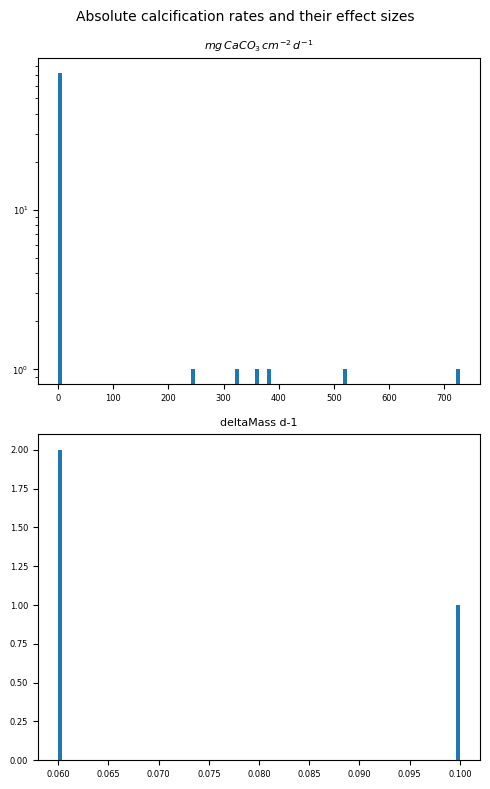

In [20]:
### visualise distributions of various calcification rates
rate_types = working_df['st_calcification_unit'].unique()
rate_types = [rate_type for rate_type in rate_types if rate_type != ""]
fig, axes = plt.subplots(len(rate_types), 1, figsize=(5, 8), dpi=100)

for i, rate_type in enumerate(rate_types):
    axes[i].hist(working_df[working_df['st_calcification_unit'] == rate_type]['st_calcification'], bins=100)
    axes[i].set_title(f"{plotting.RATE_TYPE_MAPPING.get(rate_type, rate_type)}", fontsize=8)
    
# format
for ax in axes.flatten():
    if max([p.get_height() for p in ax.patches]) > 10:
        ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=6)
    
plt.suptitle('Absolute calcification rates and their effect sizes', fontsize=10)
plt.tight_layout()

## Climatology

In [21]:
### investigate any studies which have missing or aquaria locations
missing_coords = working_df[working_df.latitude.isna() | working_df.longitude.isna()]
print(f"Number of rows without lat/lon coordinates: {len(missing_coords)}.")
print(f"These correspond to the following locations: {missing_coords.drop_duplicates('doi', keep='first').location.values}.")

aquaria_locations = working_df[working_df['location'].str.lower().str.contains('aquar', na=False)]
additional_rows = set(aquaria_locations.drop_duplicates('doi', keep='first').location.values) - set(missing_coords.drop_duplicates('doi', keep='first').location.values)
print(f'In addition, the following are aquaria with location information: {list(additional_rows)}.')
print(f'...corresponding to {len(aquaria_locations) - len(missing_coords)} additional rows.')
print(f'This makes {len(missing_coords) + len(additional_rows)} rows with spurious or missing location information.')

Number of rows without lat/lon coordinates: 0.
These correspond to the following locations: [].
In addition, the following are aquaria with location information: [].
...corresponding to 0 additional rows.
This makes 0 rows with spurious or missing location information.


In [30]:
working_df_mi

authors  \
doi                        location                           longitude   latitude                                                      
10.1038/s41598-017-10947-1 Heron Island, Great Barrier Reef    151.916667 -23.4500  Achlatis, Michelle (56584627400); Van Der Zand...   
                                                                          -23.4500  Achlatis, Michelle (56584627400); Van Der Zand...   
                                                                          -23.4500  Achlatis, Michelle (56584627400); Van Der Zand...   
                                                                          -23.4500  Achlatis, Michelle (56584627400); Van Der Zand...   
10.3354/ab00527            Orpheus Island, Great Barrier Reef -82.260000   9.3500   Wisshak, M., Schönberg, C. H., Form, A., & Fr...   
...                                                                                                                               ...   
10.1111/gcb.17371-LOC-B    Little Conch, FL, USA              -80.444500   24.9476                                               Webb   
10.5194/bg-12-567-2015     Kaneohe Bay, Hawaii                -157.800000  21.4500                               Sibliger and Donahue   
                                                                           21.4500                               Sibliger and Donahue   
                                                                           21.4500                               Sibliger and Donahue   
                                                                           21.4500                               Sibliger and Donahue   

                                                                                    calcification  \
doi                        location                           longitude   latitude                  
10.1038/s41598-017-10947-1 Heron Island, Great Barrier Reef    151.916667 -23.4500         3.4000   
                                                                          -23.4500         3.3000   
                                                                          -23.4500         2.7000   
                                                                          -23.4500         2.8000   
10.3354/ab00527            Orpheus Island, Great Barrier Reef -82.260000   9.3500          0.1500   
...                                                                                           ...   
10.1111/gcb.17371-LOC-B    Little Conch, FL, USA              -80.444500   24.9476         2.0300   
10.5194/bg-12-567-2015     Kaneohe Bay, Hawaii                -157.800000  21.4500         0.6125   
                                                                           21.4500         1.0737   
                                                                           21.4500         1.4494   
                                                                           21.4500         2.0465   

                                                                                    calcification_sd  \
doi                        location                           longitude   latitude                     
10.1038/s41598-017-10947-1 Heron Island, Great Barrier Reef    151.916667 -23.4500          1.732051   
                                                                          -23.4500          1.558846   
                                                                          -23.4500          0.866025   
                                                                          -23.4500          1.558846   
10.3354/ab00527            Orpheus Island, Great Barrier Reef -82.260000   9.3500           0.040000   
...                                                                                              ...   
10.1111/gcb.17371-LOC-B    Little Conch, FL, USA              -80.444500   24.9476          1.260000   
10.5194/bg-12-567-2015     Kaneohe Bay, Hawaii                -157.800000  21.4500          0.

In [31]:
### load climatology data
ph_climatology = processing.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'all_locations.yaml')

sst_climatology = processing.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'all_locations.yaml')

merged_clim_df = pd.merge(
    sst_climatology,
    ph_climatology,
)   # concatenated sst and ph climatology dataframes

# prepare dataframes and merge
merged_clim_df_mi = merged_clim_df.set_index(['doi', 'location', 'longitude', 'latitude'])
working_df_mi = working_df.set_index(['doi', 'location', 'longitude', 'latitude'])
working_clim_df = working_df_mi.join(merged_clim_df_mi, how='inner')

print(f"There are {len(merged_clim_df_mi.index.unique())} unique locations in the climatology data compared with {len(working_df.drop_duplicates('doi', keep='first'))} location counts in the working dataframe.")

# exclude locations mentioning non-tropical ranges, so retrieved climatology data is not relevant
working_clim_df = working_clim_df[~working_clim_df.index.get_level_values('location').str.contains('monaco|portugal', case=False, na=False)]

There are 198 unique locations in the climatology data compared with 16 location counts in the working dataframe.


/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/processing.py:499: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = (df.copy()).replace(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/processing.py:499: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = (df.copy()).replace(


In [32]:
### calculate the global average anomalies for each scenario and time_frame
future_global_anomaly_df = merged_clim_df_mi.reset_index().groupby(['scenario', 'time_frame']).agg(
    mean_sst_anomaly=('mean_sst_20y_anomaly_ensemble', 'mean'),
    mean_ph_anomaly=('mean_ph_20y_anomaly_ensemble', 'mean'),
).reset_index()
future_global_anomaly_df.head()

scenario  time_frame  mean_sst_anomaly  mean_ph_anomaly
0   ssp126        2030          0.766832        -0.064873
1   ssp126        2050          1.036569        -0.090197
2   ssp126        2090          1.152233        -0.085236
3   ssp245        2030          0.763936        -0.068710
4   ssp245        2050          1.209769        -0.115864

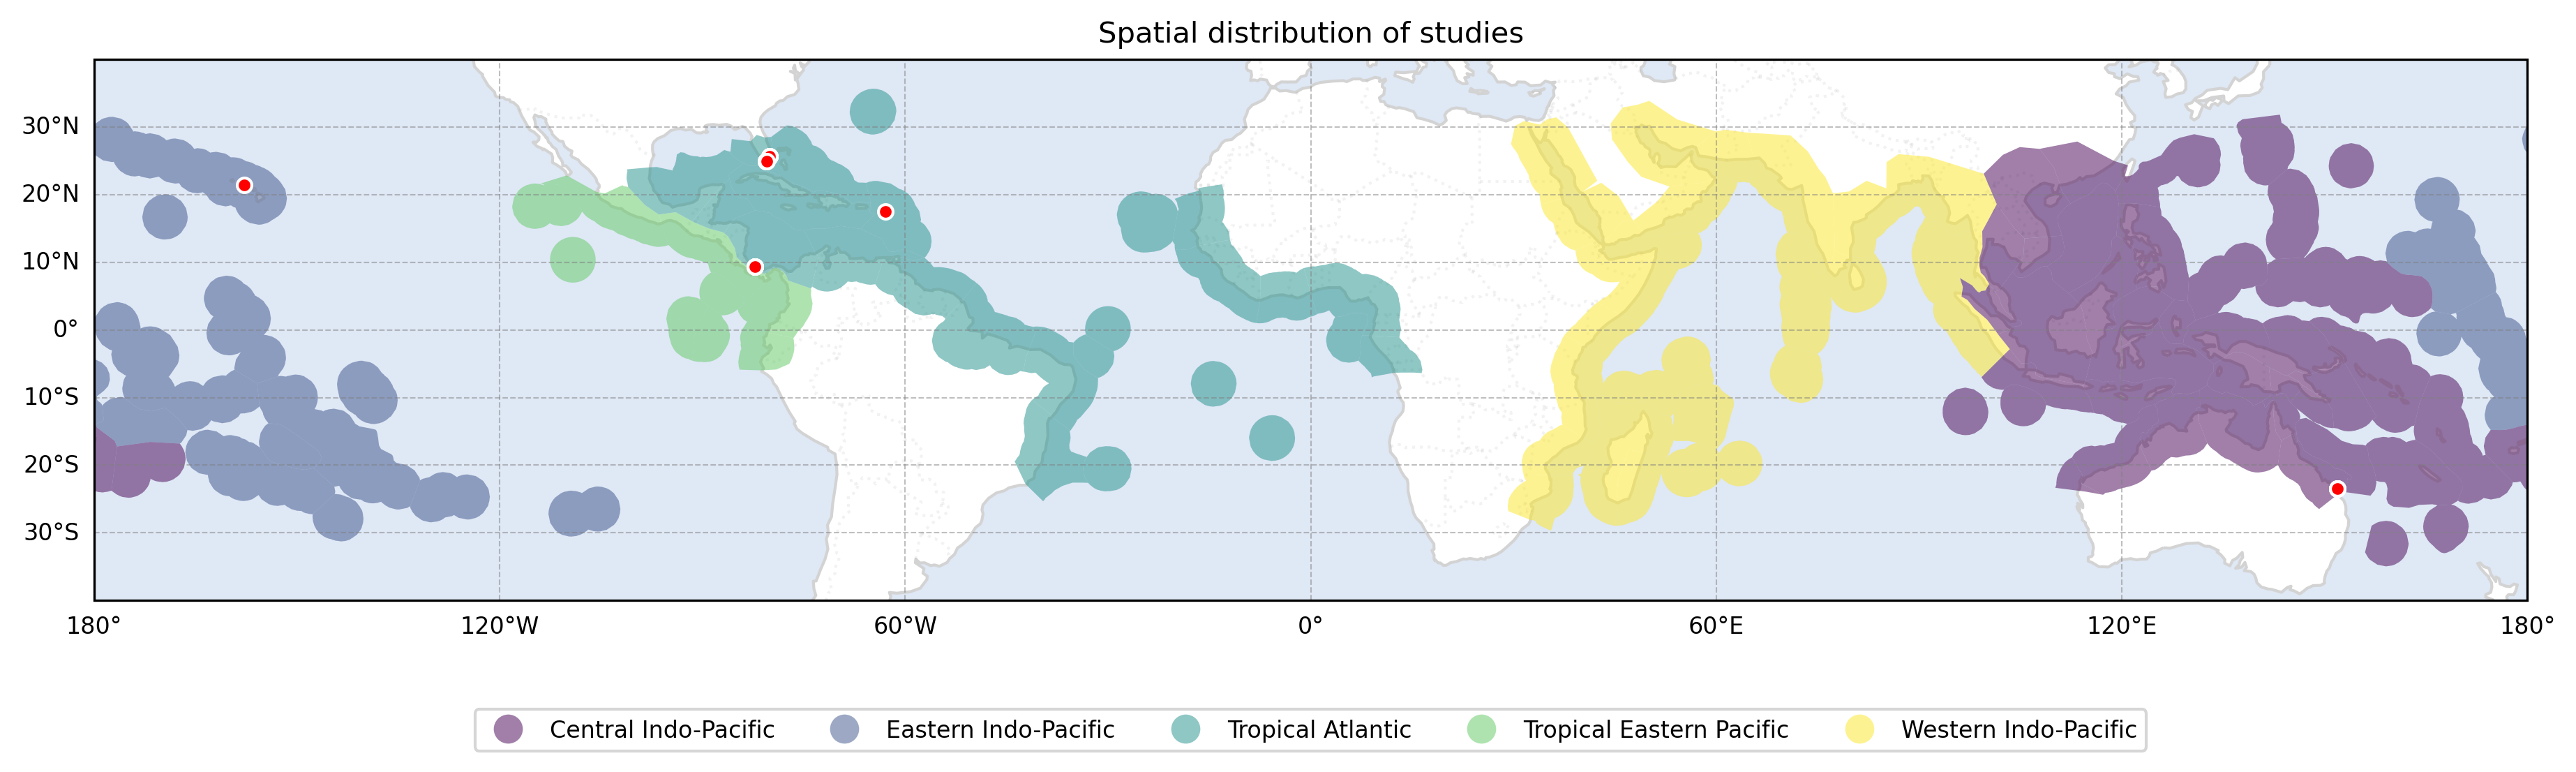

(<Figure size 4500x3000 with 1 Axes>,
 <GeoAxes: title={'center': 'Spatial distribution of studies'}>)

In [24]:
### visualise study distribution
plotting.plot_areas_with_study_locations(working_df.drop_duplicates('doi', keep='first'))

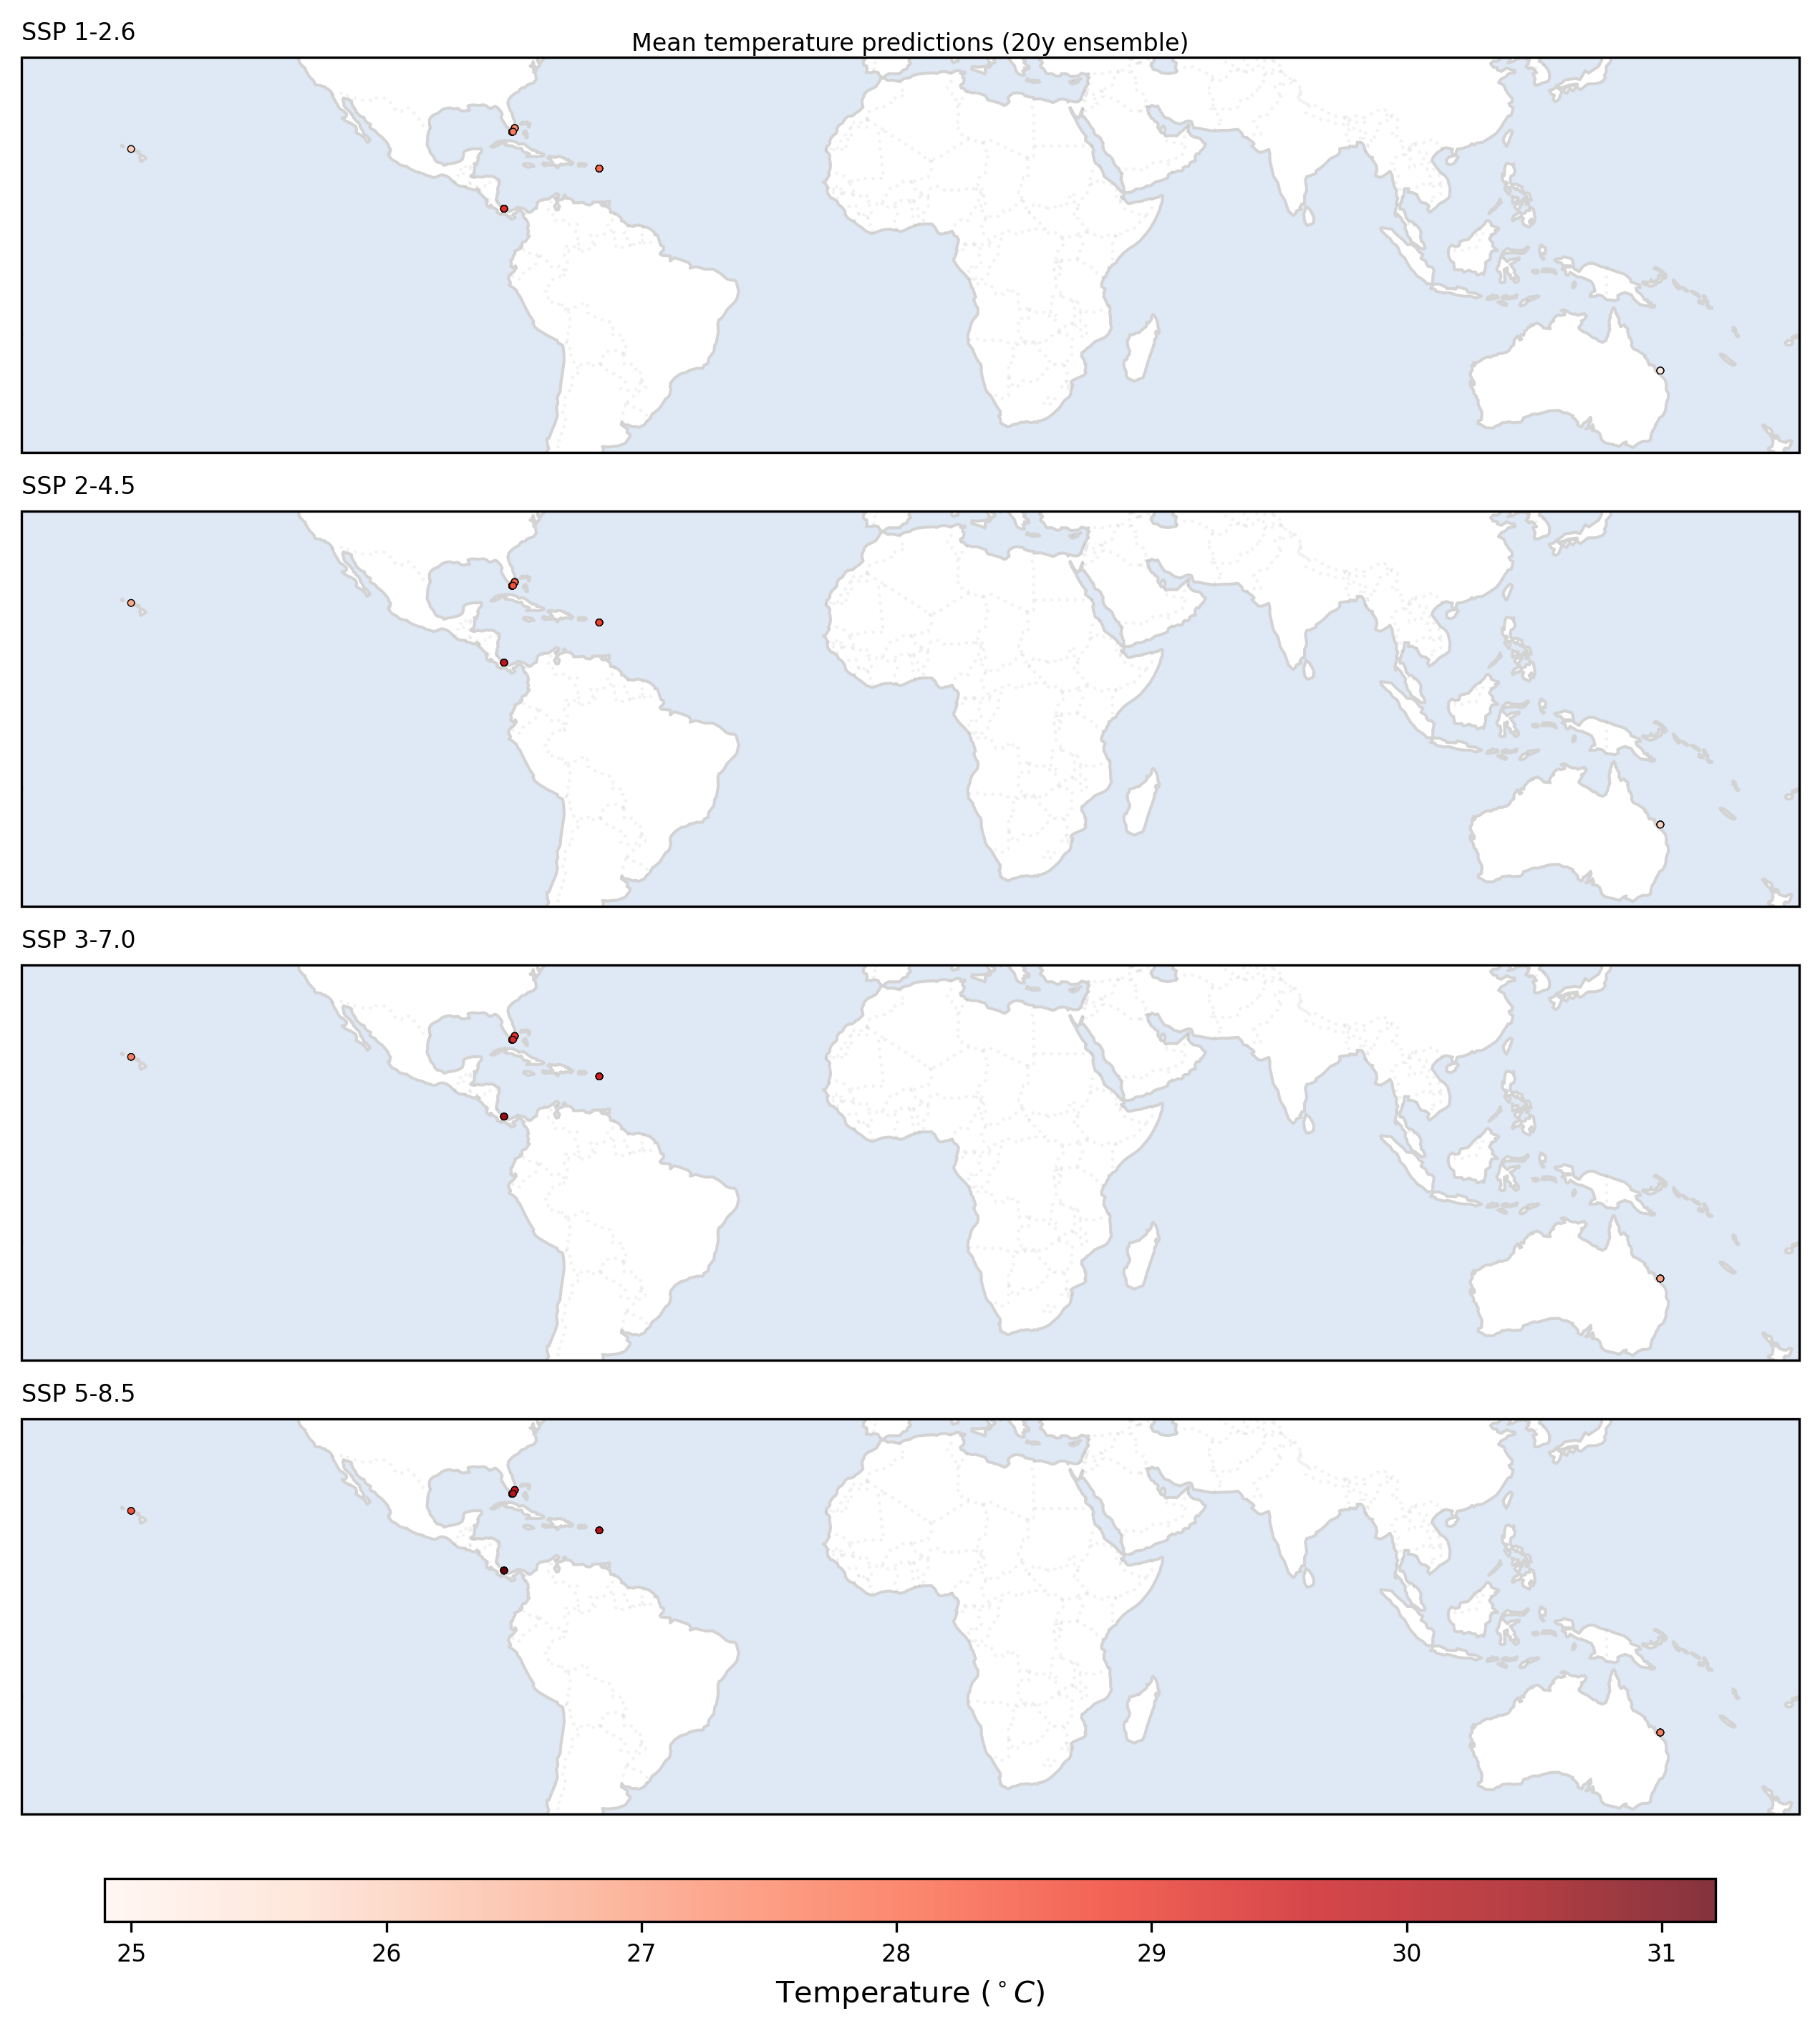

In [34]:
### visualise forecasted mean temperatures, by SSP
fig, axes = plotting.plot_spatial_effect_distribution(working_clim_df.reset_index(), var_to_plot='mean_sst_20y_ensemble', title='Mean temperature predictions (20y ensemble)', cbar_label='Temperature ($^\\circ C$)', reverse_cmap=False);

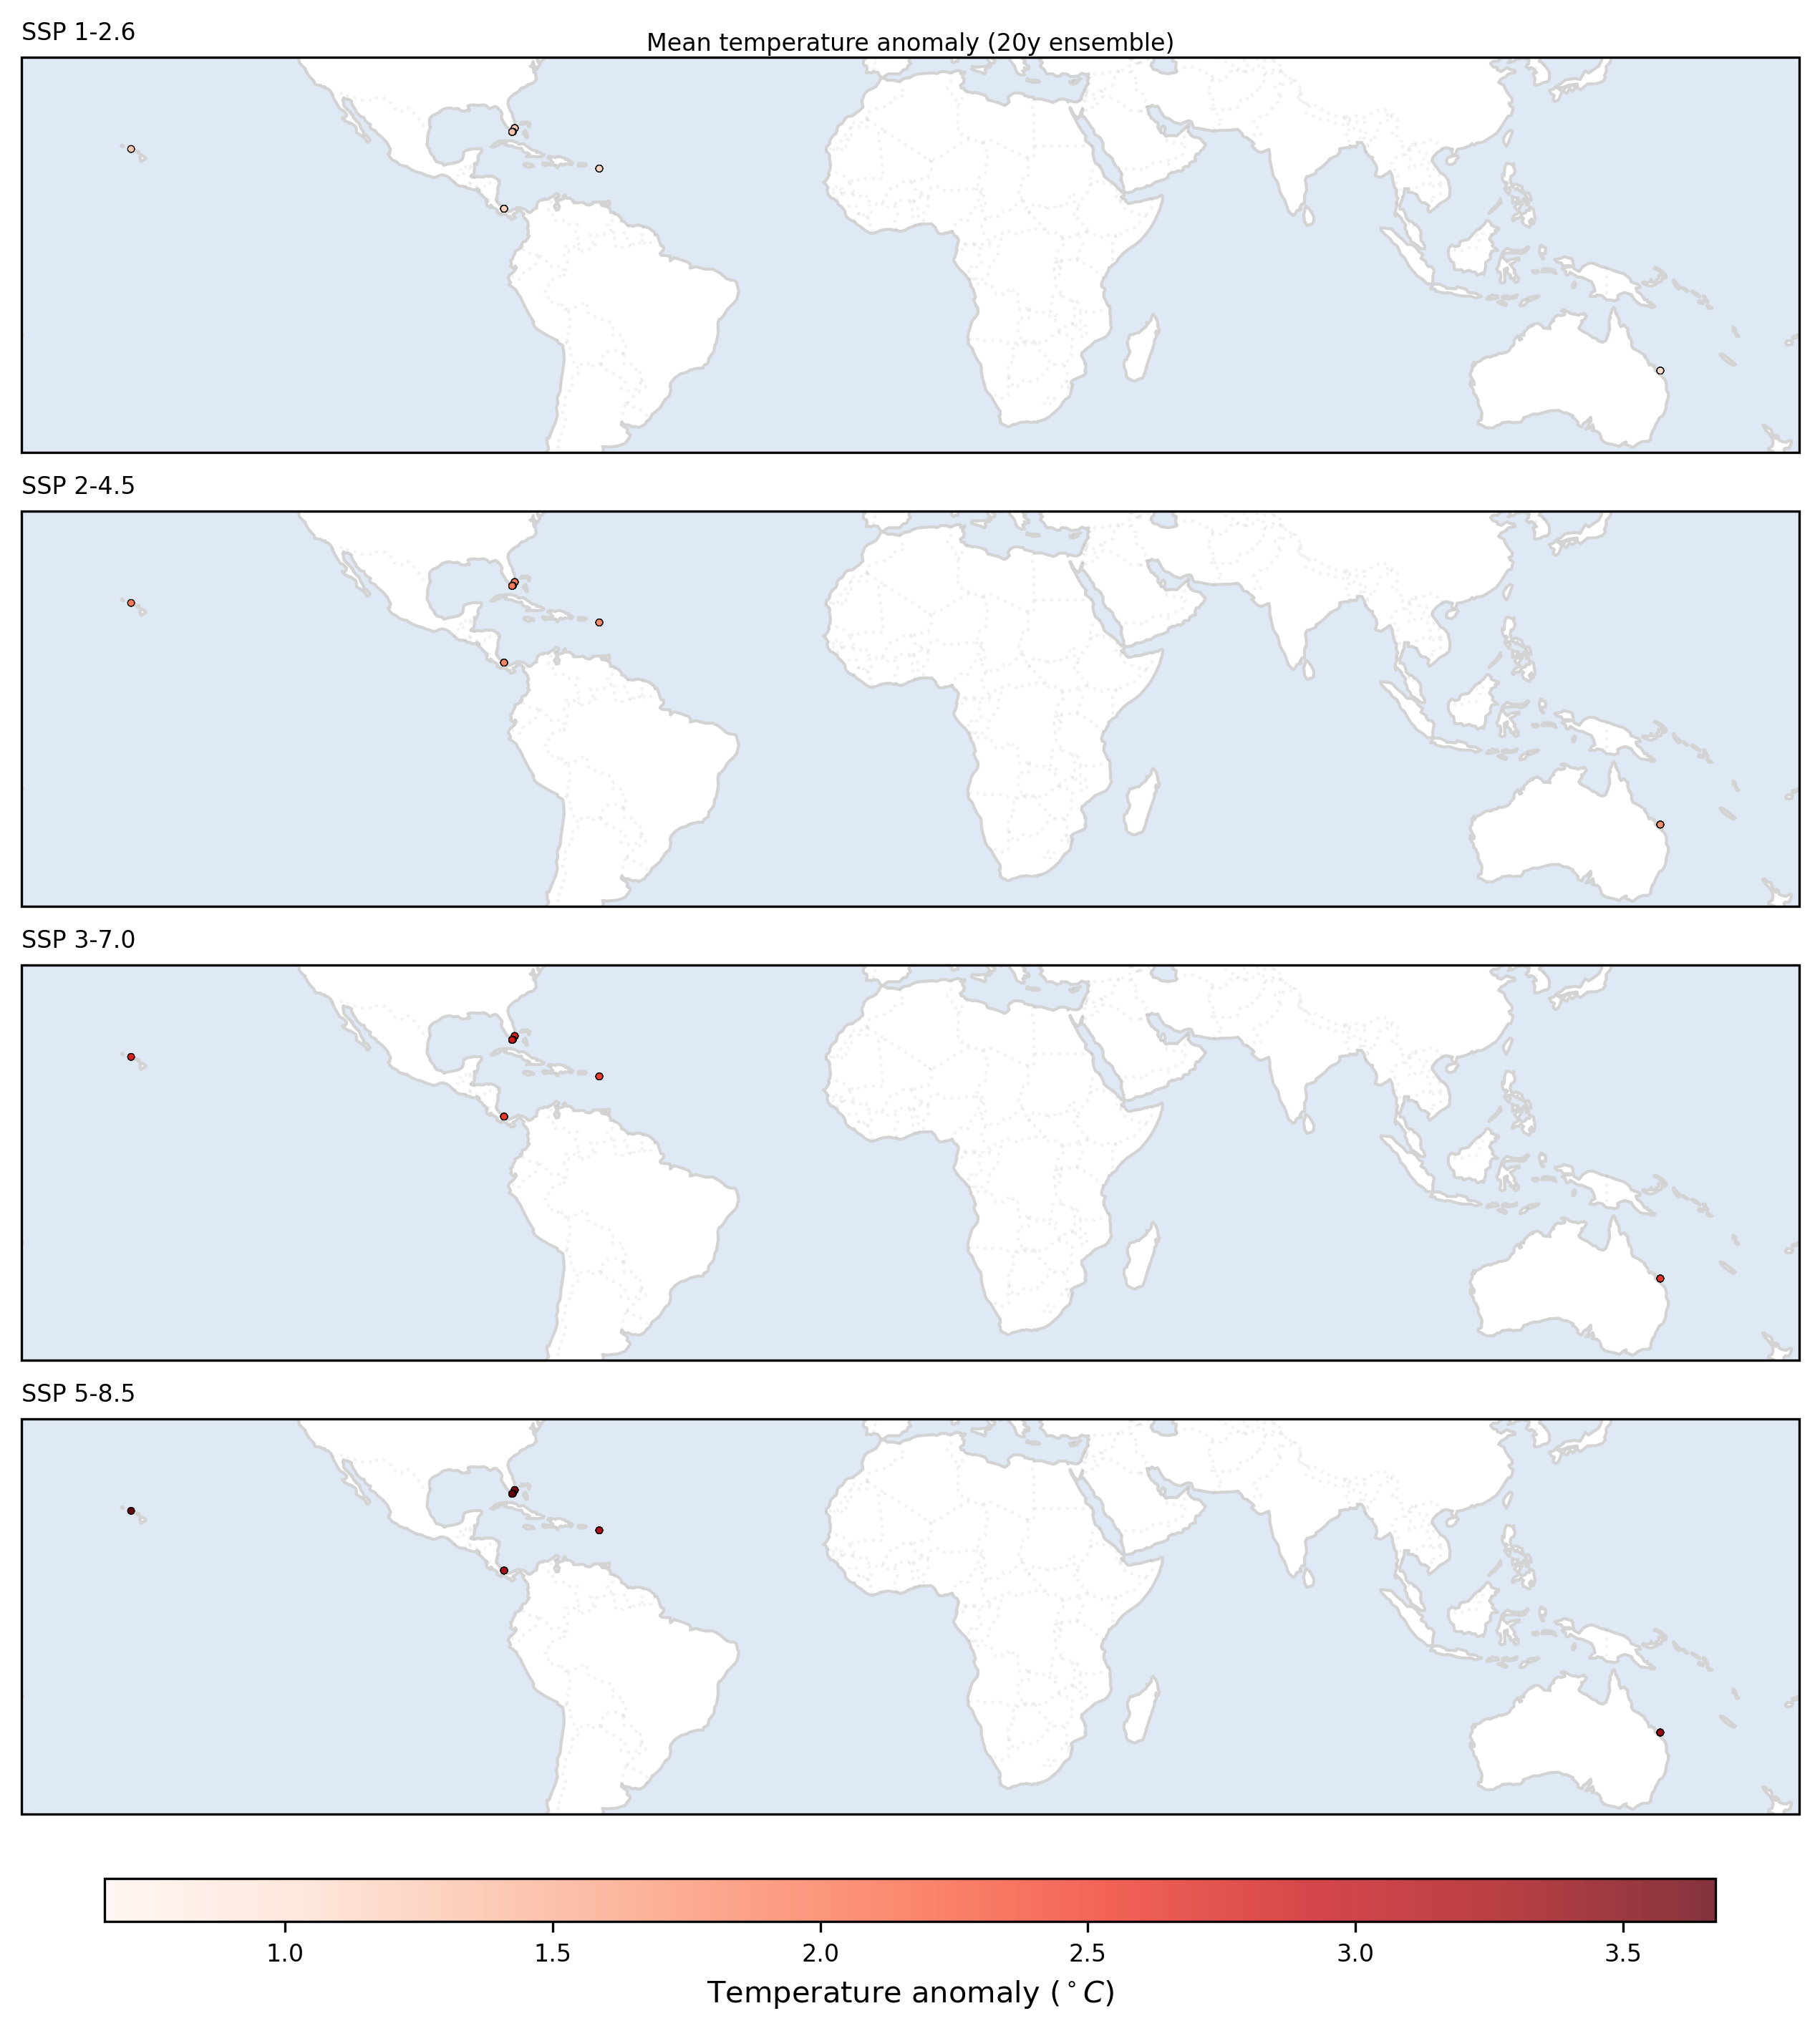

In [35]:
### visualise forecasted mean temperature anomalies, by SSP
fig, axes = plotting.plot_spatial_effect_distribution(working_clim_df.reset_index(), var_to_plot='mean_sst_20y_anomaly_ensemble', title='Mean temperature anomaly (20y ensemble)', cbar_label='Temperature anomaly ($^\\circ C$)', reverse_cmap=False);

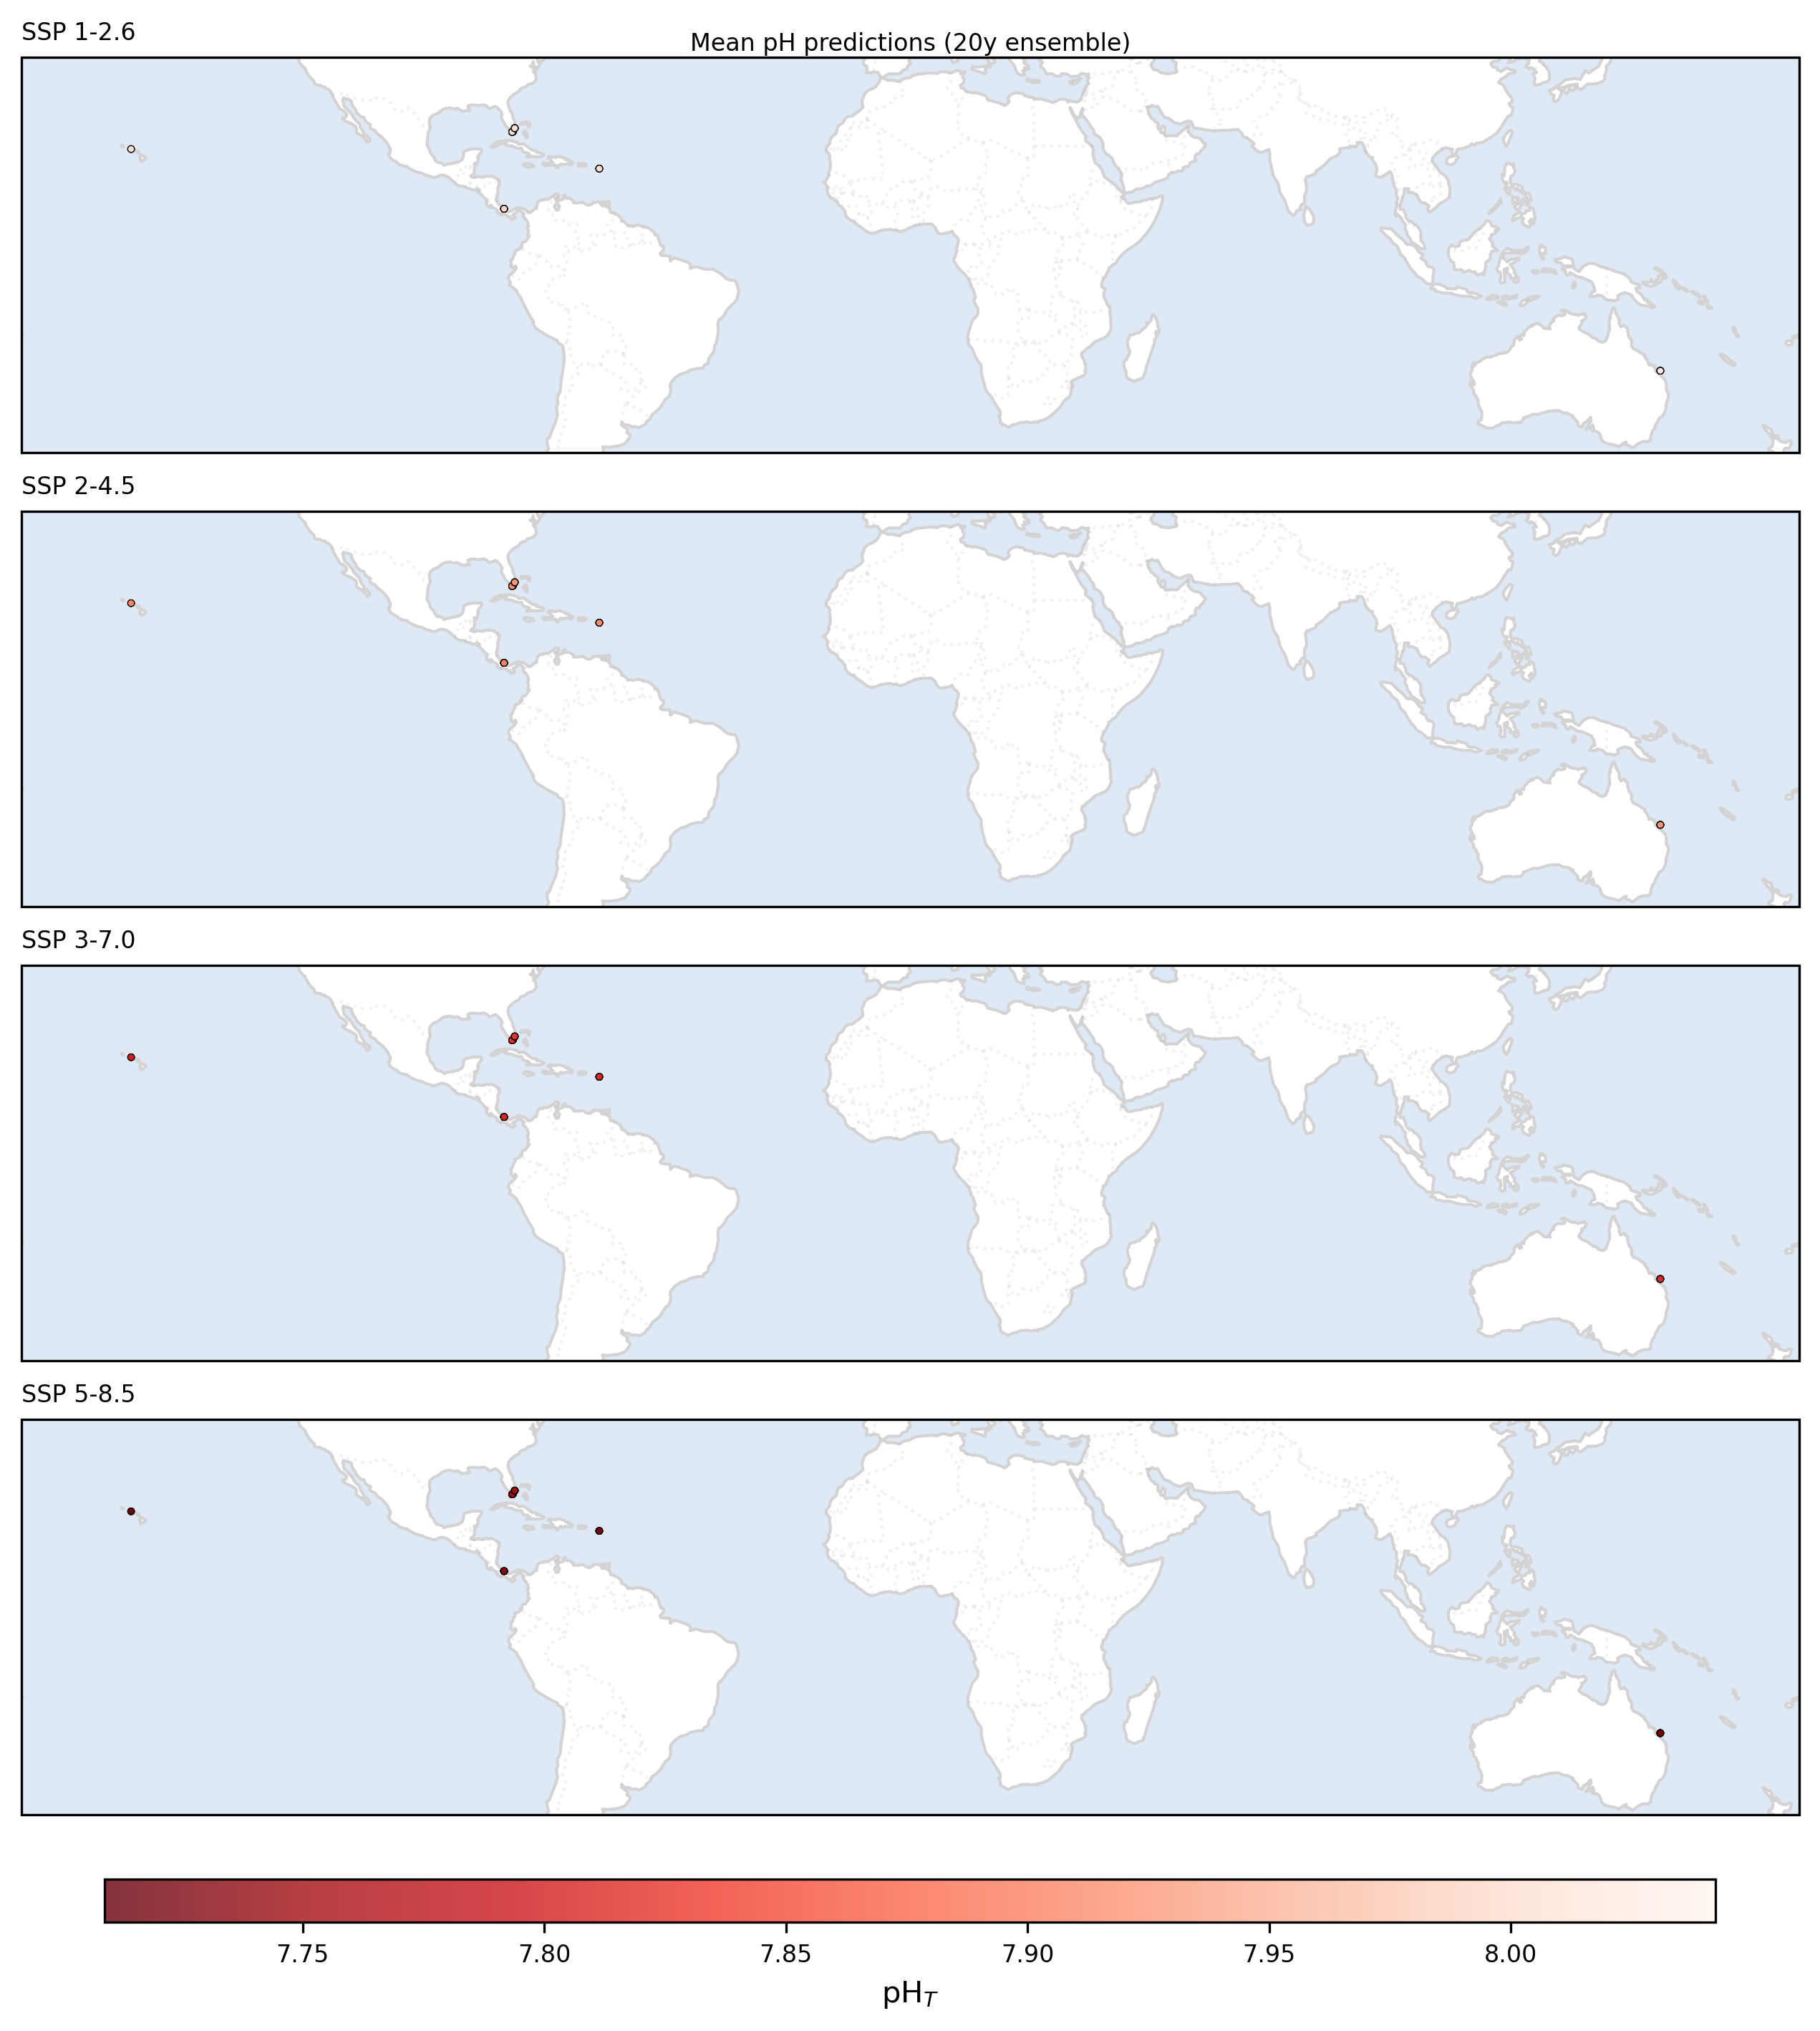

In [36]:
### visualise forecasted mean pH, by SSP
fig, axes = plotting.plot_spatial_effect_distribution(working_clim_df.reset_index(), var_to_plot='mean_ph_20y_ensemble', title='Mean pH predictions (20y ensemble)', cbar_label='pH$_T$', reverse_cmap=True);

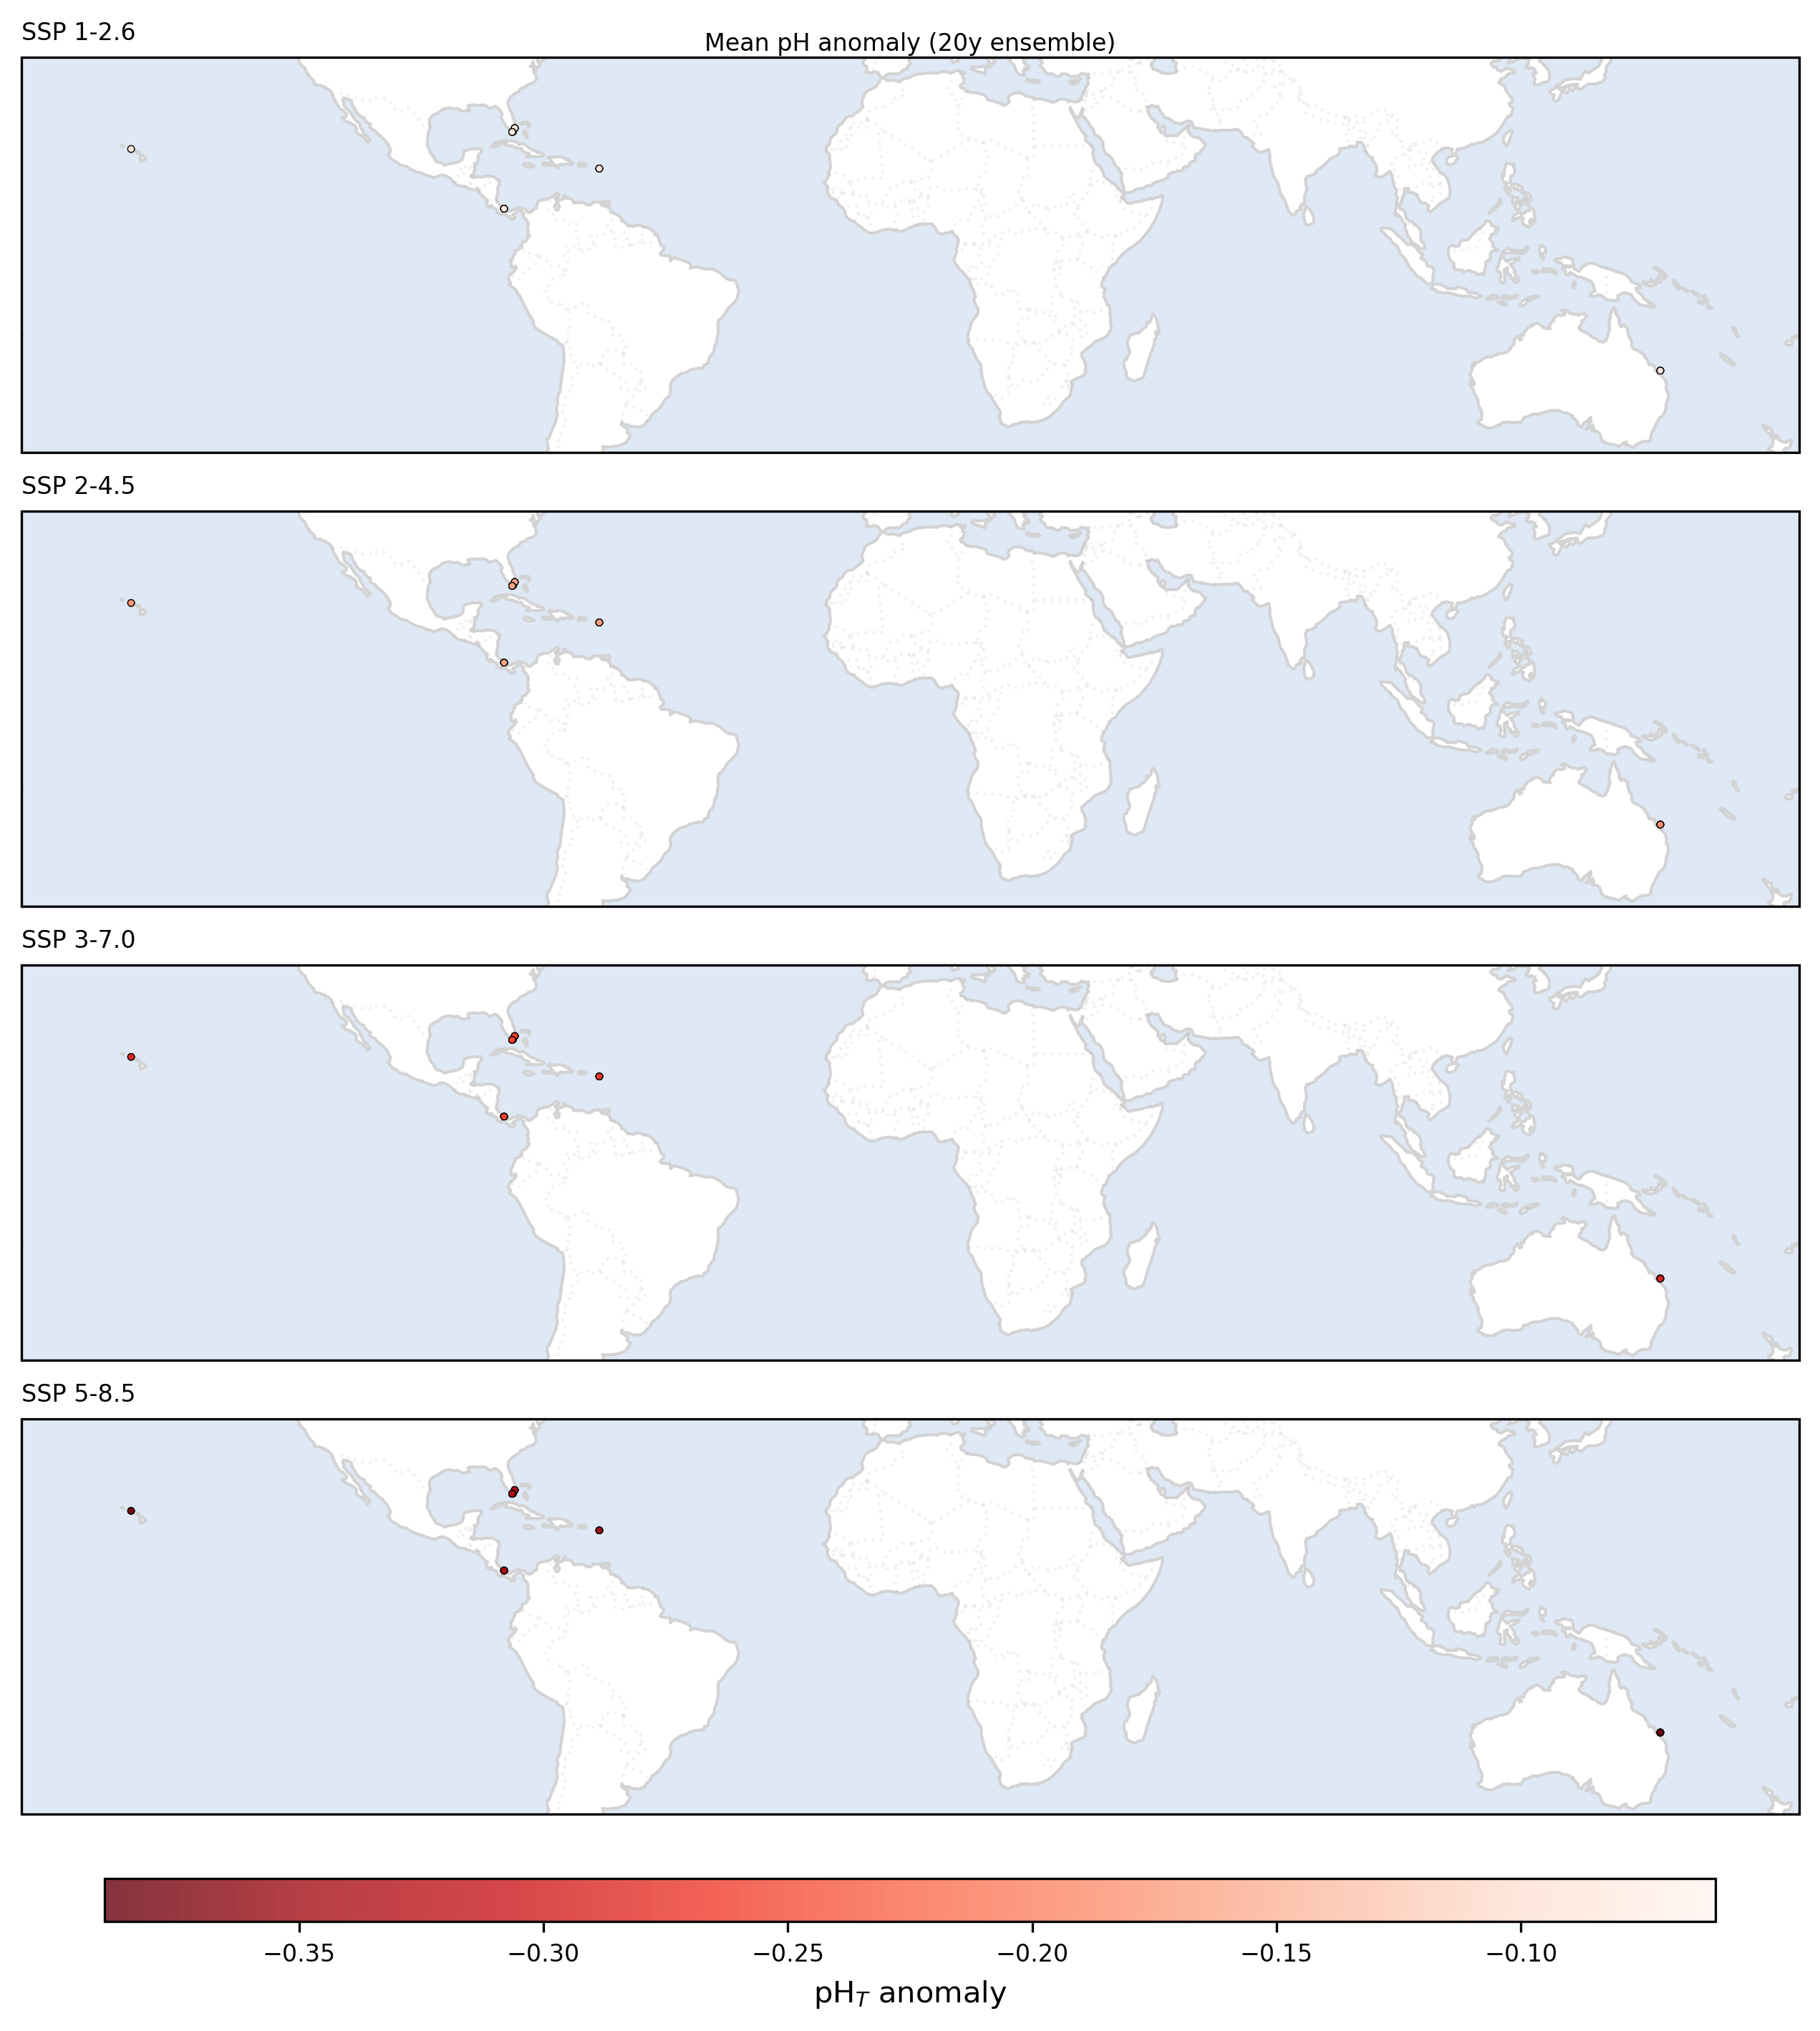

In [37]:
### visualise forecasted mean pH anomalies, by SSP
fig, axes = plotting.plot_spatial_effect_distribution(working_clim_df.reset_index(), var_to_plot='mean_ph_20y_anomaly_ensemble', title='Mean pH anomaly (20y ensemble)', cbar_label='pH$_T$ anomaly', reverse_cmap=True);

## Variable-calcification visualisations

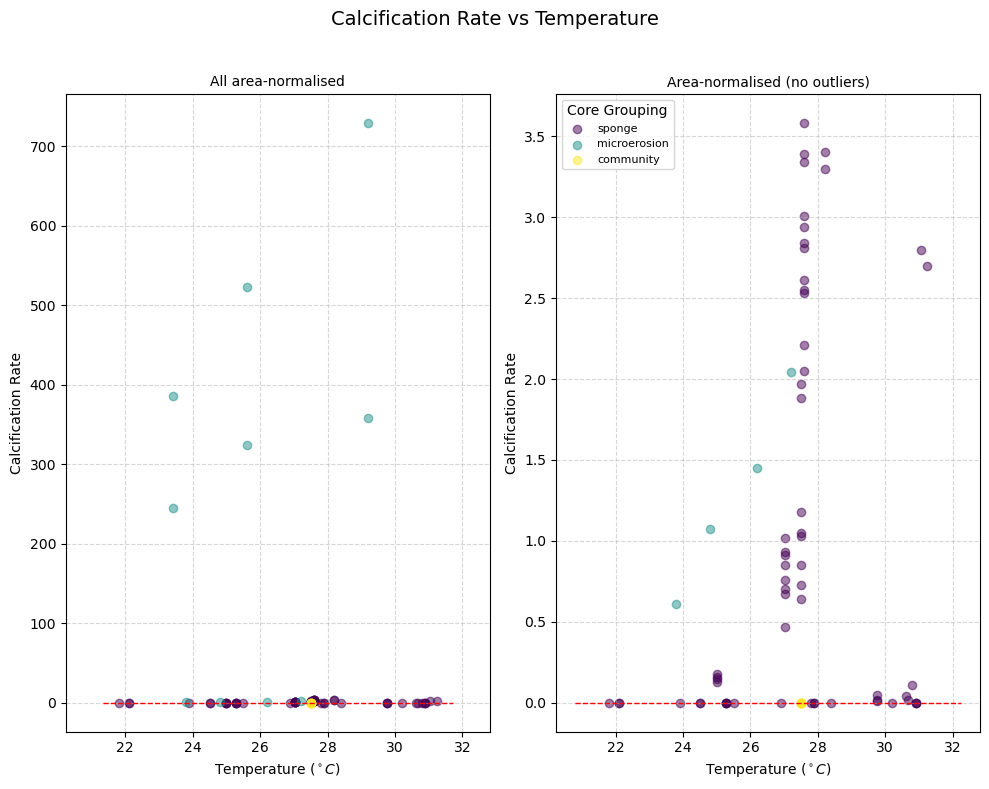

In [38]:
### naive plotting of calcification rates against absolute values of temperature
area_norm_df = working_df[working_df['st_calcification_unit'] == 'mgCaCO3 cm-2d-1'].copy()  # most reasonable unit

# TODO: these currently assigned by sight due to large inherent variance
area_norm_no_outliers_df = area_norm_df[
    (area_norm_df.st_calcification > -10) &
    (area_norm_df.st_calcification < 10)
]   

fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharex=True)
group_color_map = {
    group: color
    for group, color in zip(
        area_norm_df['core_grouping'].dropna().unique(),
        plt.cm.viridis(np.linspace(0, 1, area_norm_df['core_grouping'].nunique()))
    )
}

plots = [
    (0, area_norm_df, 'All area-normalised'),
    (1, area_norm_no_outliers_df, 'Area-normalised (no outliers)'),
]

for col, df, title in plots:
    ax = axes[col]
    for group, color in group_color_map.items():
        subset = df[df['core_grouping'] == group]
        ax.scatter(subset['temp'], subset['st_calcification'], color=color, label=group, alpha=0.5)
    # format
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Temperature ($^\\circ C$)')
    ax.set_ylabel('Calcification Rate')
    ax.grid(ls='--', alpha=0.5)
    ax.hlines(0, *ax.get_xlim(), color='red', linestyle='--', linewidth=1)
    if col == 1:
        ax.legend(title="Core Grouping", loc='upper left', fontsize=8)

fig.suptitle('Calcification Rate vs Temperature', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])


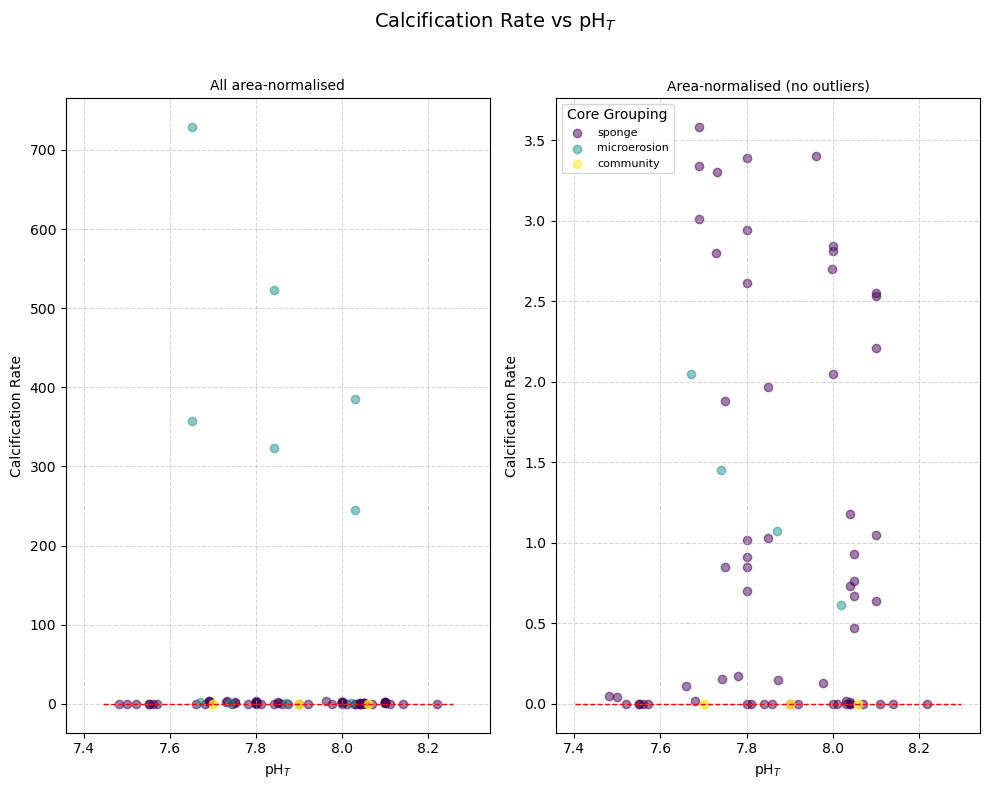

In [39]:
### naive plotting of calcification rates against absolute values of pH for main unit subset (mgCaCO3 cm-2d-1)
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharex=True)
group_color_map = {
    group: color
    for group, color in zip(
        area_norm_df['core_grouping'].dropna().unique(),
        plt.cm.viridis(np.linspace(0, 1, area_norm_df['core_grouping'].nunique()))
    )
}

plots = [
    (0, area_norm_df, 'All area-normalised'),
    (1, area_norm_no_outliers_df, 'Area-normalised (no outliers)'),
]

for col, df, title in plots:
    ax = axes[col]
    for group, color in group_color_map.items():
        subset = df[df['core_grouping'] == group]
        ax.scatter(subset['phtot'], subset['st_calcification'], color=color, label=group, alpha=0.5)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('pH$_T$')
    ax.set_ylabel('Calcification Rate')
    ax.grid(ls='--', alpha=0.5)
    ax.hlines(0, *ax.get_xlim(), color='red', linestyle='--', linewidth=1)
    if col == 1:
        ax.legend(title="Core Grouping", loc='upper left', fontsize=8)

fig.suptitle('Calcification Rate vs pH$_T$', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


In [40]:
### area-normalised rate against temperature nad pH, in 3D
area_norm_no_outliers_df.loc[:, 'points_weights'] = np.sqrt(area_norm_no_outliers_df['st_calcification_sd']).copy()
px.scatter_3d(
    area_norm_no_outliers_df,
    x='temp',
    y='phtot',
    z='st_calcification',
    color='core_grouping',
    title='3D Scatter plot of Standardized Calcification vs Temperature and pH',
    labels={'temp': 'Temperature', 'phtot': 'pH', 'st_calcification': 'Standardized Calcification'},
    hover_name='species_types',
    opacity=0.5,
    size='points_weights',
    width=800,
    height=800,
)


/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_23805/3260677609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_norm_no_outliers_df.loc[:, 'points_weights'] = np.sqrt(area_norm_no_outliers_df['st_calcification_sd']).copy()


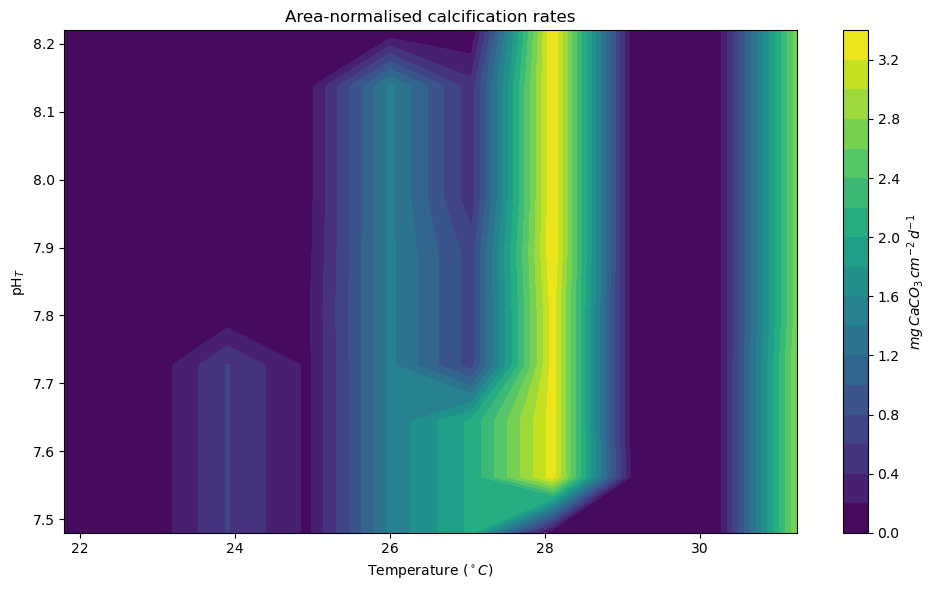

In [41]:
### contour plot of calcification rates against temperature and pH
fig, ax = plt.subplots(figsize=(10, 6), sharex=True)
npoints = 10

area_x = np.linspace(area_norm_no_outliers_df.temp.min(), area_norm_no_outliers_df.temp.max(), npoints)  # Temperature range
area_y = np.linspace(area_norm_no_outliers_df.phtot.min(), area_norm_no_outliers_df.phtot.max(), npoints)  # pH range

plotting.plot_contour(ax, area_x, area_y, area_norm_no_outliers_df, 'Area-normalised calcification rates', legend_label=r'$mg \, CaCO_3 \, cm^{-2} \, d^{-1}$')

plt.tight_layout()

## Effect sizes

First, an exploration of how treatments/effects are computed

In [44]:
effect_type = 'st_relative_calcification'

In [45]:
### generating effect sizes
effects_df = analysis.calculate_effect_for_df(working_df).reset_index(drop=True)
# errors thrown up re no control data due to questionable studies (excluding explicitly adapted studies)
print(f'Shape of dataframe with effect sizes: {effects_df.shape}')
print(effects_df['treatment'].value_counts())
working_effects_df = effects_df.copy()
effect_sizes=['cohens_d', 'hedges_g', 'relative_calcification', 'absolute_calcification', 'st_relative_calcification', 'st_absolute_calcification']

# reverse sign of effects, since bioerosion is the extracted as positive values (positive is CaCO3 lost: opposite of calcification)
for effect in effect_sizes:
    working_effects_df[effect] = -1 * working_effects_df[effect]

  0%|          | 0/16 [00:00<?, ?it/s]

Shape of dataframe with effect sizes: (68, 118)
treatment
phtot            33
phtot_temp_mv    13
temp_mv           9
phtot_mv          8
temp              5
Name: count, dtype: int64


In [46]:
### relative calcification as function of temperature and pH, in 3D
working_effects_df[f'{effect_type}_var'] = pd.to_numeric(working_effects_df[f'{effect_type}_var'], errors='coerce')

working_effects_df.loc[:, 'points_weights'] = np.sqrt(pd.to_numeric(working_effects_df[f'{effect_type}_var'], errors='coerce'))
px.scatter_3d(
    working_effects_df,
    x='temp',
    y='phtot',
    z='st_relative_calcification',
    color='core_grouping',
    title='3D Scatter plot of Standardized Calcification vs Temperature and pH',
    labels={'temp': 'Temperature', 'phtot': 'pH', 'st_relative_calcification': 'Relative standardized Calcification'},
    hover_name='species_types',
    opacity=0.5,
    size='points_weights',
    width=800,
    height=800,
)


In [47]:
### relative calcification as function of DELTA(temperature) and DELTA(pH), in 3D

working_effects_df[f'{effect_type}_var'] = pd.to_numeric(working_effects_df[f'{effect_type}_var'], errors='coerce')

working_effects_df.loc[:, 'points_weights'] = np.sqrt(pd.to_numeric(working_effects_df['st_relative_calcification_var'], errors='coerce'))
px.scatter_3d(
    working_effects_df,
    x='delta_t',
    y='delta_ph',
    z='st_relative_calcification',
    color='core_grouping',
    title='3D Scatter plot of Standardized Calcification vs Temperature and pH',
    labels={'temp': 'Temperature', 'phtot': 'pH', 'st_relative_calcification': 'Relative standardized Calcification'},
    hover_name='species_types',
    opacity=0.5,
    size='points_weights',
    width=800,
    height=800,
)

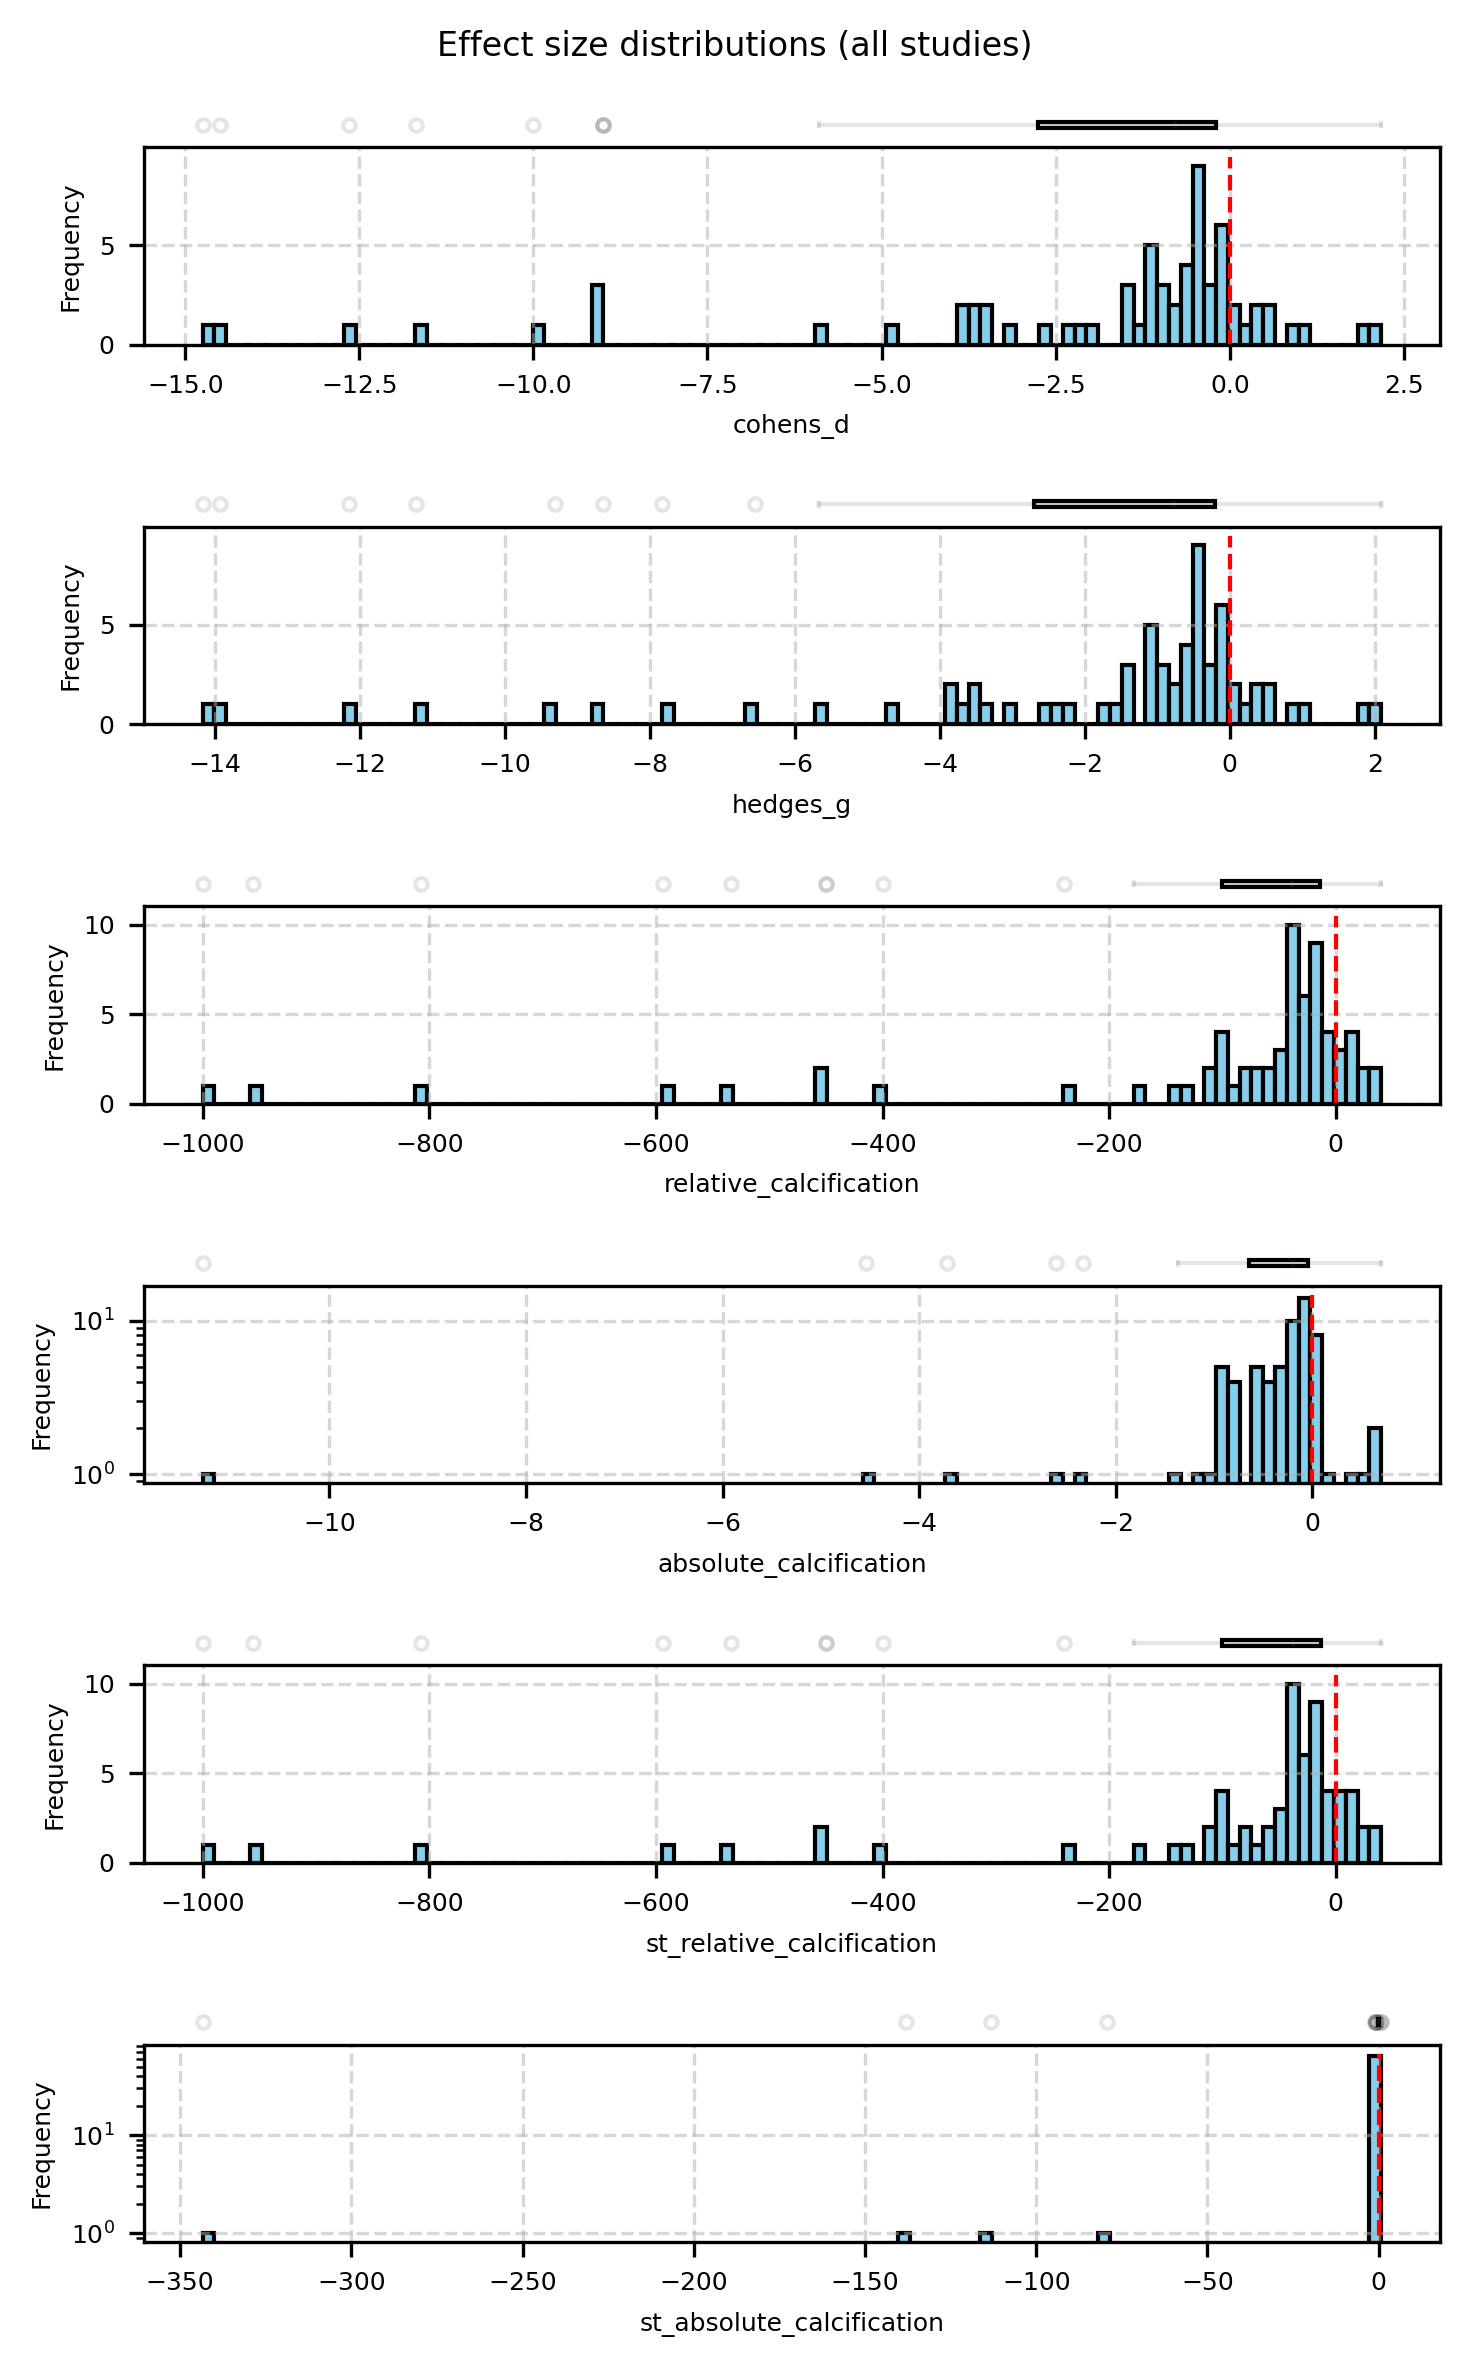

In [48]:
### visualise distributions of effect sizes
plotting.plot_effect_size_distributions(
    working_effects_df, title='Effect size distributions (all studies)',
)

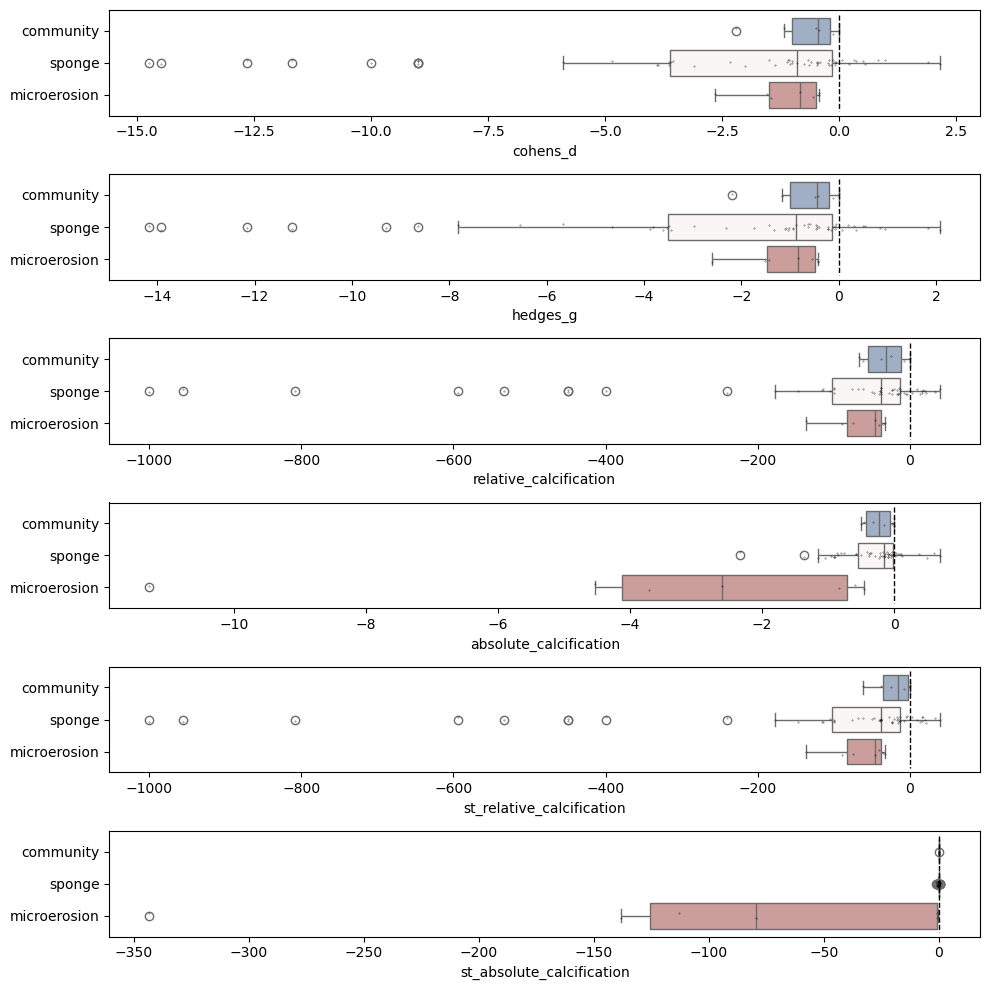

In [49]:
### break down effect size by core_grouping
fig, axes = plt.subplots(len(effect_sizes), 1, figsize=(10, 10), sharex=False)

for i, effect_size in enumerate(effect_sizes):    # plot the effect sizes for each core grouping
    sns.boxplot(
        data=working_effects_df,
        x=effect_size,
        y='core_grouping',
        palette='vlag',
        hue='core_grouping',
        ax=axes[i],
    )
    sns.stripplot(
        data=working_effects_df,
        x=effect_size,
        y='core_grouping',
        ax=axes[i],
        alpha=0.3,
        marker='x',
        s=1,
        color='black',
        linewidth=1
    )
    axes[i].vlines(
        x=0,
        ymin=-0.5,
        ymax=len(working_effects_df['core_grouping'].unique()) - 0.5,
        color='black',
        linestyle='--',
        linewidth=1,
        zorder=10
    )
    axes[i].set_ylabel('')
plt.tight_layout()

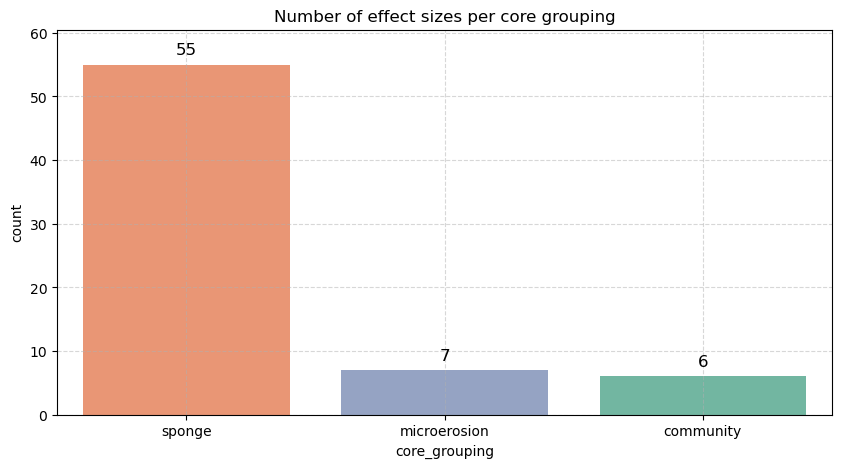

In [50]:
### visualise the number of effect sizes per core grouping
fig, ax = plt.subplots(figsize=(10, 5))

count_order = working_effects_df['core_grouping'].value_counts().index  # order by number of effect sizes
sns.countplot(
    data=working_effects_df,
    x='core_grouping',
    order=count_order,
    palette='Set2',
    hue='core_grouping',
)

# format
for i, value in enumerate(working_effects_df['core_grouping'].value_counts().values):
    plt.annotate(f'{int(value)}', (i, value), ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
plt.ylim(0, working_effects_df['core_grouping'].value_counts().max() * 1.1)
plt.title('Number of effect sizes per core grouping')
plt.grid(ls='--', alpha=0.5)

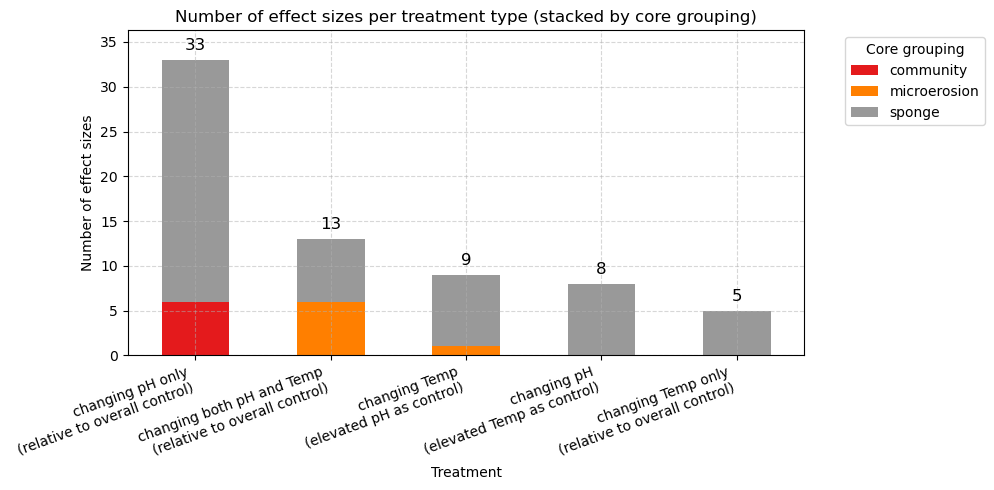

In [51]:
### visualise the number of effect sizes per treatment, stacked by core_grouping
fig, ax = plt.subplots(figsize=(10, 5))

# group by treatment and core_grouping, then count occurrences
stacked_data = working_effects_df.groupby(['treatment', 'core_grouping']).size().unstack(fill_value=0)
ordered_treatments = stacked_data.sum(axis=1).sort_values(ascending=False).index
# plot
stacked_data.loc[ordered_treatments].plot(kind='bar', stacked=True, ax=ax, colormap='Set1')

# format
plt.title('Number of effect sizes per treatment type (stacked by core grouping)')
plt.xlabel('Treatment')
plt.ylabel('Number of effect sizes')
plt.grid(ls='--', alpha=0.5)
for i, value in enumerate(stacked_data.loc[ordered_treatments].sum(axis=1).values):
    plt.annotate(f'{int(value)}', (i, value), ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
plt.ylim(0, stacked_data.loc[ordered_treatments].sum(axis=1).max() * 1.1)

# update the x-ticks with the treatment names
treatment_map = {
    'phtot': 'changing pH only\n(relative to overall control)',
    'temp': 'changing Temp only\n(relative to overall control)',
    'phtot_mv': 'changing pH\n(elevated Temp as control)',
    'temp_mv': 'changing Temp\n(elevated pH as control)',
    'phtot_temp_mv': 'changing both pH and Temp\n(relative to overall control)',
}
ax.set_xticklabels([treatment_map.get(treatment, treatment) for treatment in ordered_treatments], rotation=20, ha='right')

# legend
plt.legend(title='Core grouping', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

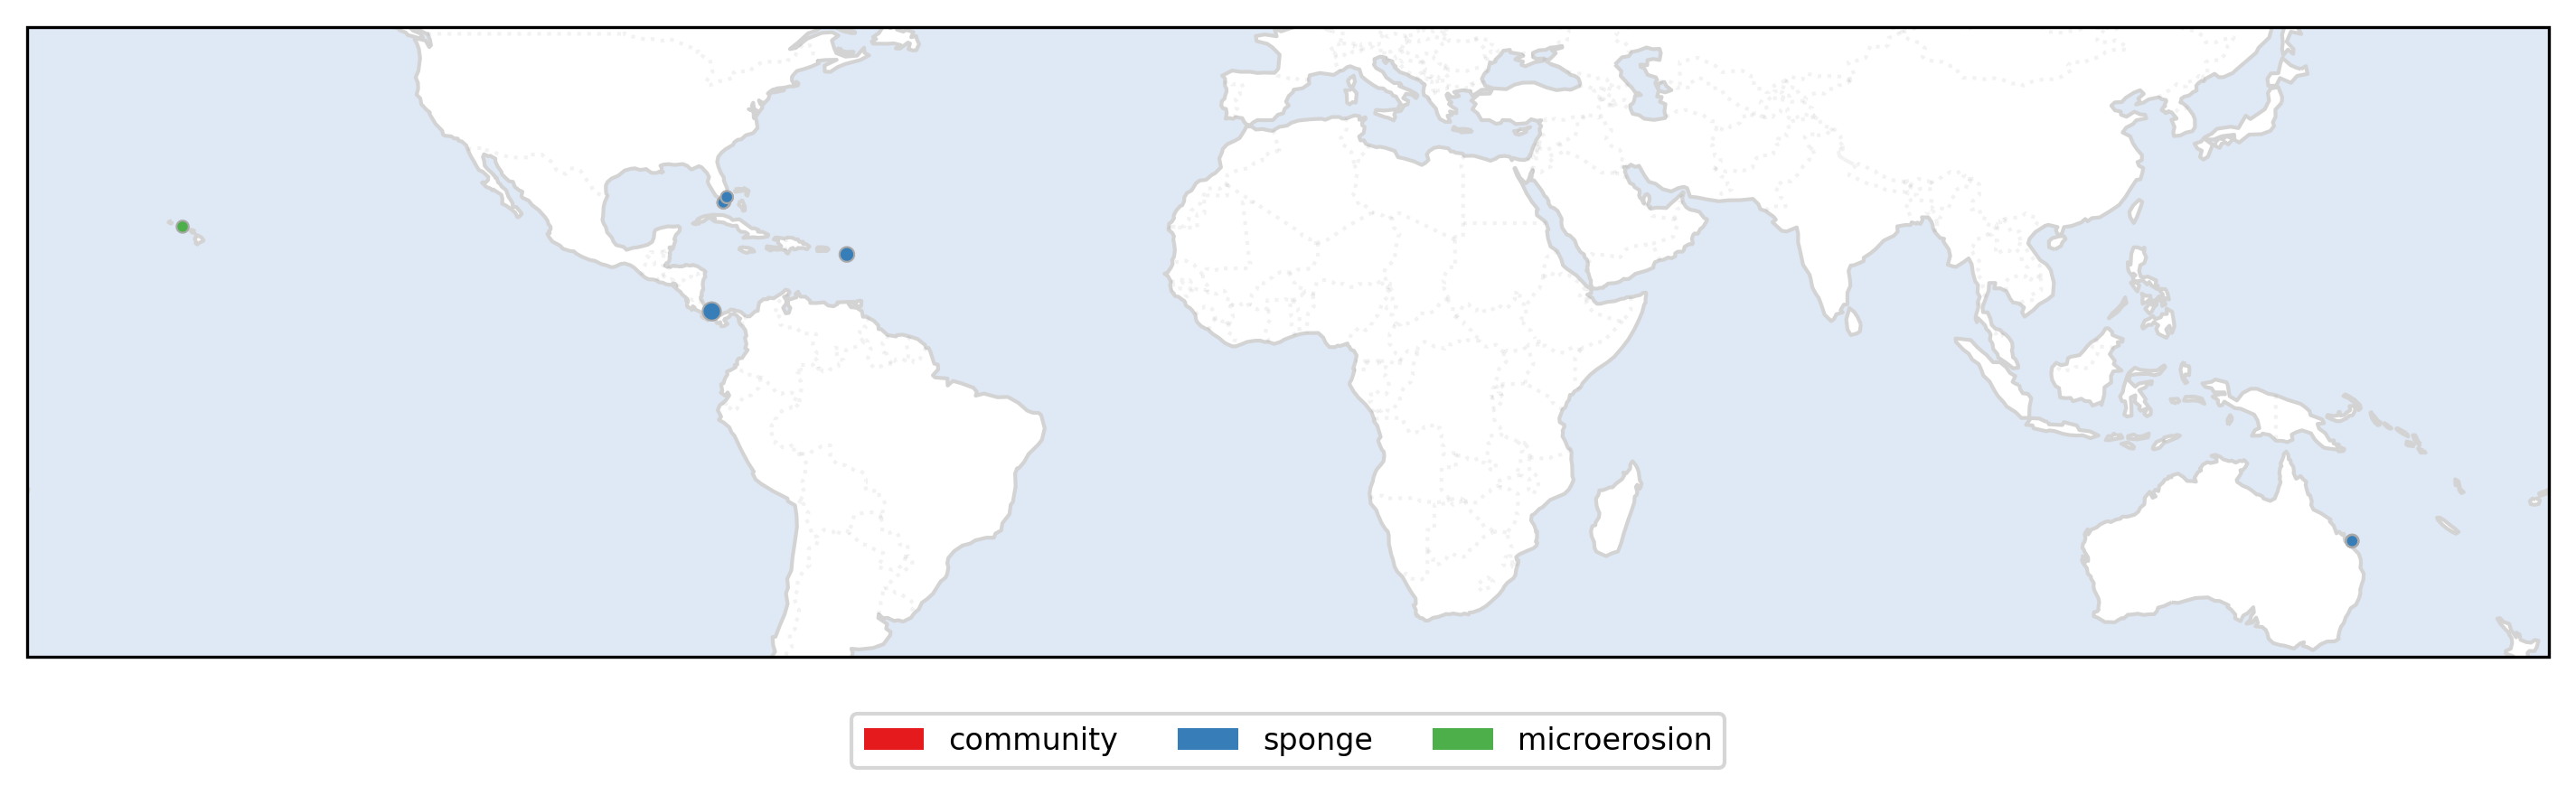

In [52]:
### plot the ratio of effect size types as pie charts on a map
fig, ax = plt.subplots(figsize=(12, 6), dpi=300,
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax = plotting.format_geo_axes(ax)

unique_groups = working_effects_df['core_grouping'].unique()
group_colors = {grp: color for grp, color in zip(unique_groups, plt.cm.Set1.colors)}

for doi, group in working_effects_df.groupby('doi'):
    if group['latitude'].isna().any() or group['longitude'].isna().any():
        print(f"Skipping DOI {doi} due to missing latitude/longitude.")
        continue
    lat = group['latitude'].values[0]
    lon = group['longitude'].values[0]

    group_counts = group['core_grouping'].value_counts()    # count number of effect sizes per core_grouping within this DOI
    
    if group_counts.empty or group_counts.sum() == 0:   # if nothing to plot, or zero counts
        continue
    sizes = group_counts.values
    labels = group_counts.index
    
    # only plot groups with non-zero counts
    valid_indices = [i for i, size in enumerate(sizes) if size > 0] 
    if not valid_indices:
        continue
    sizes = [sizes[i] for i in valid_indices]
    labels = [labels[i] for i in valid_indices]
    colors = [group_colors[labels[i]] for i in valid_indices]

    # scale pie chart size by total number of effect sizes
    n_effect_sizes = sum(sizes)
    size = 0.05 + n_effect_sizes * 0.002  # manually tweaked

    # create inset axis at the study's geographic location
    pie_ax = inset_axes(ax,
                        width=size,
                        height=size,
                        loc='center',
                        bbox_to_anchor=(lon, lat),
                        bbox_transform=ax.transData,
                        borderpad=0,
                        )
    if len(sizes) > 0:
        wedges, _ = pie_ax.pie(sizes, colors=colors, startangle=90, wedgeprops={'edgecolor': 'darkgrey', 'linewidth': 0.5})
        pie_ax.set_aspect("equal")
        pie_ax.axis('off')  # hide pie chart axis

legend_elements = [Patch(facecolor=group_colors[grp], label=str(grp)) 
                  for grp in unique_groups]
ax.legend(handles=legend_elements,
         loc='lower center', bbox_to_anchor=(0.5, -0.2), ncols=len(unique_groups), fontsize=8,
         )

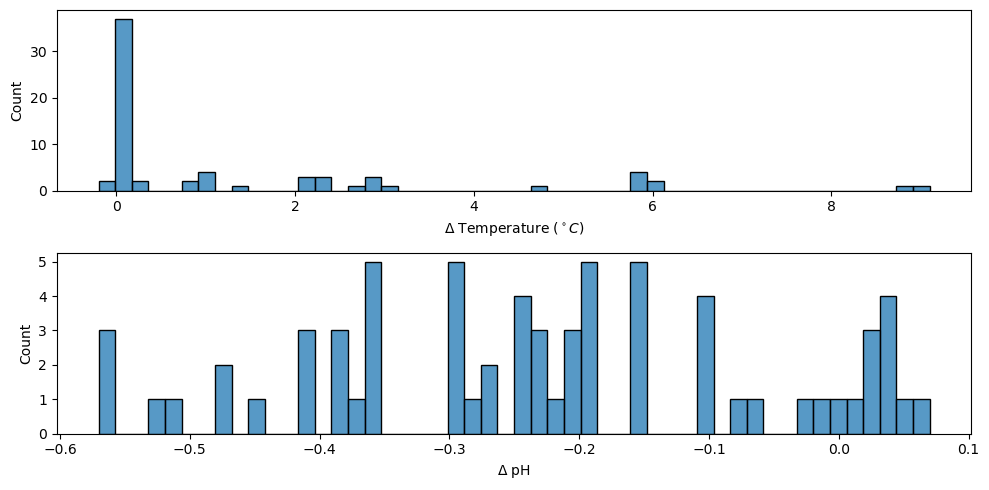

In [53]:
### plot distribution of delta ph and delta_t
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
sns.histplot(
    data=working_effects_df,
    x='delta_t',
    bins=50,
    ax=axes[0],
)
axes[0].set_xlabel('$\\Delta$ Temperature ($^\\circ C$)')
sns.histplot(
    data=working_effects_df,
    x='delta_ph',
    bins=50,
    ax=axes[1],
)
axes[1].set_xlabel('$\\Delta$ pH')
plt.tight_layout()

## Meta-regression

In [54]:
### set effect type for all proceeding cells
effect_type = "st_relative_calcification"
print(f'{working_effects_df.treatment.value_counts()}\n\t\t of {len(working_effects_df)} total effect sizes')

treatment
phtot            33
phtot_temp_mv    13
temp_mv           9
phtot_mv          8
temp              5
Name: count, dtype: int64
		 of 68 total effect sizes


In [55]:
### ILLUSTRATING INTERCEPT (CARBONATE CHEMISTRY ONLY)
expected_model, expected_model_summary, expected_model_formula, _ = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment=['phtot', 'temp', 'phtot_temp_mv'],
    formula = f"{effect_type} ~ delta_ph + delta_t"
)
print(expected_model_summary)

expected_model, expected_model_summary, expected_model_formula, _ = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment=['phtot', 'temp', 'phtot_temp_mv'],
    formula = f"{effect_type} ~ delta_ph + delta_t - 1"
)
print(expected_model_summary)


----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  68
Total samples of relevant investigation:  51
Dropped due to NaN values in required columns: 0
Final sample count: 51 (17 rows dropped)

Removed 3 outlier(s) (from 51 samples) based on Cook's distance threshold of 0.50
Using formula st_relative_calcification ~ delta_ph + delta_t

Running metafor model...
Model fitting complete.

Multivariate Meta-Analysis Model (k = 48; method: REML)

   logLik   Deviance        AIC        BIC       AICc   
-237.1400   474.2799   484.2799   493.3132   485.8184   

Variance Components:

               estim     sqrt  nlvls  fixed           factor 
sigma^2.1  1218.7826  34.9111     13     no     original_doi 
sigma^2.2   889.3002  29.8211     48     no  original_doi/ID 

Test for Residual Heterogeneity:
QE(df = 45) = 1769.9559, p-val < .0001

Test of Moderators (coefficients 2:3):
QM(df = 2) = 12.0119, p-val = 0.0025

Model Results:

          e

In [56]:
### INDIVIDUAL TREATMENTS
ph_model, ph_model_summary, ph_model_formula, _ = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment=['phtot', 'temp', 'phtot_temp_mv'],
    formula = f"{effect_type} ~ delta_ph"
)
print(ph_model_summary)

temp_model, temp_model_summary, temp_model_formula, _ = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment=['phtot', 'temp', 'phtot_temp_mv'],
    formula = f"{effect_type} ~ delta_t"
)
print(temp_model_summary)


----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  68
Total samples of relevant investigation:  51
Dropped due to NaN values in required columns: 0
Final sample count: 51 (17 rows dropped)

Removed 3 outlier(s) (from 51 samples) based on Cook's distance threshold of 0.40
Using formula st_relative_calcification ~ delta_ph

Running metafor model...
Model fitting complete.

Multivariate Meta-Analysis Model (k = 48; method: REML)

   logLik   Deviance        AIC        BIC       AICc   
-242.8115   485.6230   493.6230   500.9375   494.5986   

Variance Components:

               estim     sqrt  nlvls  fixed           factor 
sigma^2.1   626.2603  25.0252     13     no     original_doi 
sigma^2.2  1105.5850  33.2503     48     no  original_doi/ID 

Test for Residual Heterogeneity:
QE(df = 46) = 1796.5006, p-val < .0001

Test of Moderators (coefficient 2):
QM(df = 1) = 6.2935, p-val = 0.0121

Model Results:

          estimate       

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Extra argument ('useS4') disregarded. 

R[write to console]: 2: Extra argument ('useS4') disregarded. 

R[write to console]: 3: Extra argument ('useS4') disregarded. 

R[write to console]: 4: Extra argument ('useS4') disregarded. 

R[write to console]: 5: Extra argument ('useS4') disregarded. 




----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  68
Total samples of relevant investigation:  51
Dropped due to NaN values in required columns: 0
Final sample count: 51 (17 rows dropped)

Removed 3 outlier(s) (from 51 samples) based on Cook's distance threshold of 0.40
Using formula st_relative_calcification ~ delta_ph * delta_t

Running metafor model...
Model fitting complete.

Multivariate Meta-Analysis Model (k = 48; method: REML)

   logLik   Deviance        AIC        BIC       AICc   
-227.1068   454.2137   466.2137   476.9188   468.4839   

Variance Components:

               estim     sqrt  nlvls  fixed           factor 
sigma^2.1  1134.4029  33.6809     13     no     original_doi 
sigma^2.2   660.6876  25.7038     48     no  original_doi/ID 

Test for Residual Heterogeneity:
QE(df = 44) = 1769.7346, p-val < .0001

Test of Moderators (coefficients 2:4):
QM(df = 3) = 27.0919, p-val < .0001

Model Results:

            

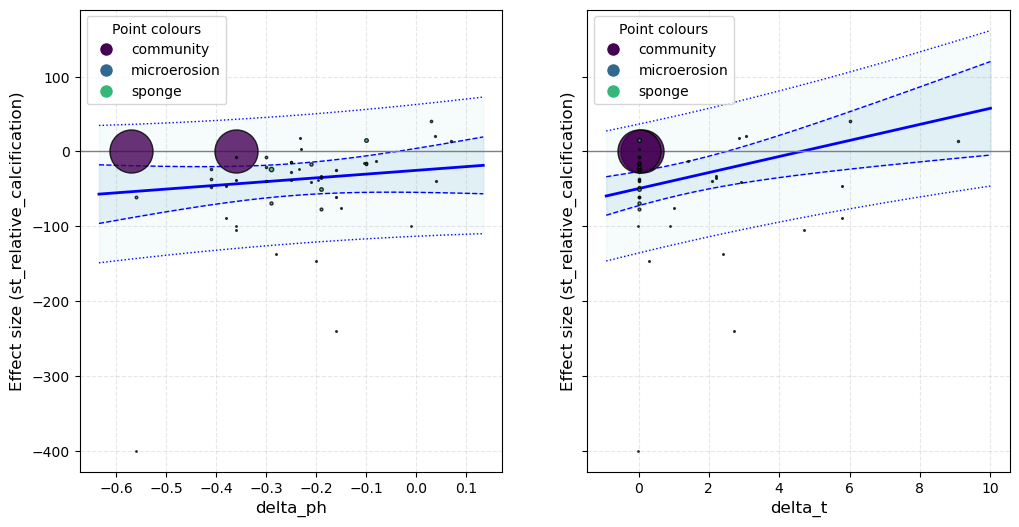

In [57]:
### INTERACTIVE + CORE GROUPS
interaction_model, interaction_model_summary, interaction_model_formula, interaction_df = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment=['phtot', 'temp', 'phtot_temp_mv'],
    formula = f"{effect_type} ~ delta_ph * delta_t"
    # formula = f"{effect_type} ~ delta_ph * delta_t + factor(core_grouping) - 1"
)
print(interaction_model_summary)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
reg_fig, ph_reg_ax = plotting.meta_regplot(
    model=interaction_model,
    model_comps = analysis.get_formula_components(interaction_model_formula),
    x_mod = 'delta_ph',
    pi=True,
    ax=axes[0],
    colorby=interaction_df['core_grouping'],
    future_global_anomaly_df=future_global_anomaly_df,
    scenario_var='ph',
)

reg_fig, ph_reg_ax = plotting.meta_regplot(
    model=interaction_model,
    model_comps = analysis.get_formula_components(interaction_model_formula),
    x_mod = 'delta_t',
    pi=True,
    ax=axes[1],
    colorby=interaction_df['core_grouping'],
    future_global_anomaly_df=future_global_anomaly_df,
    scenario_var='sst',
)

(<Figure size 3000x2400 with 1 Axes>, <Axes: >)

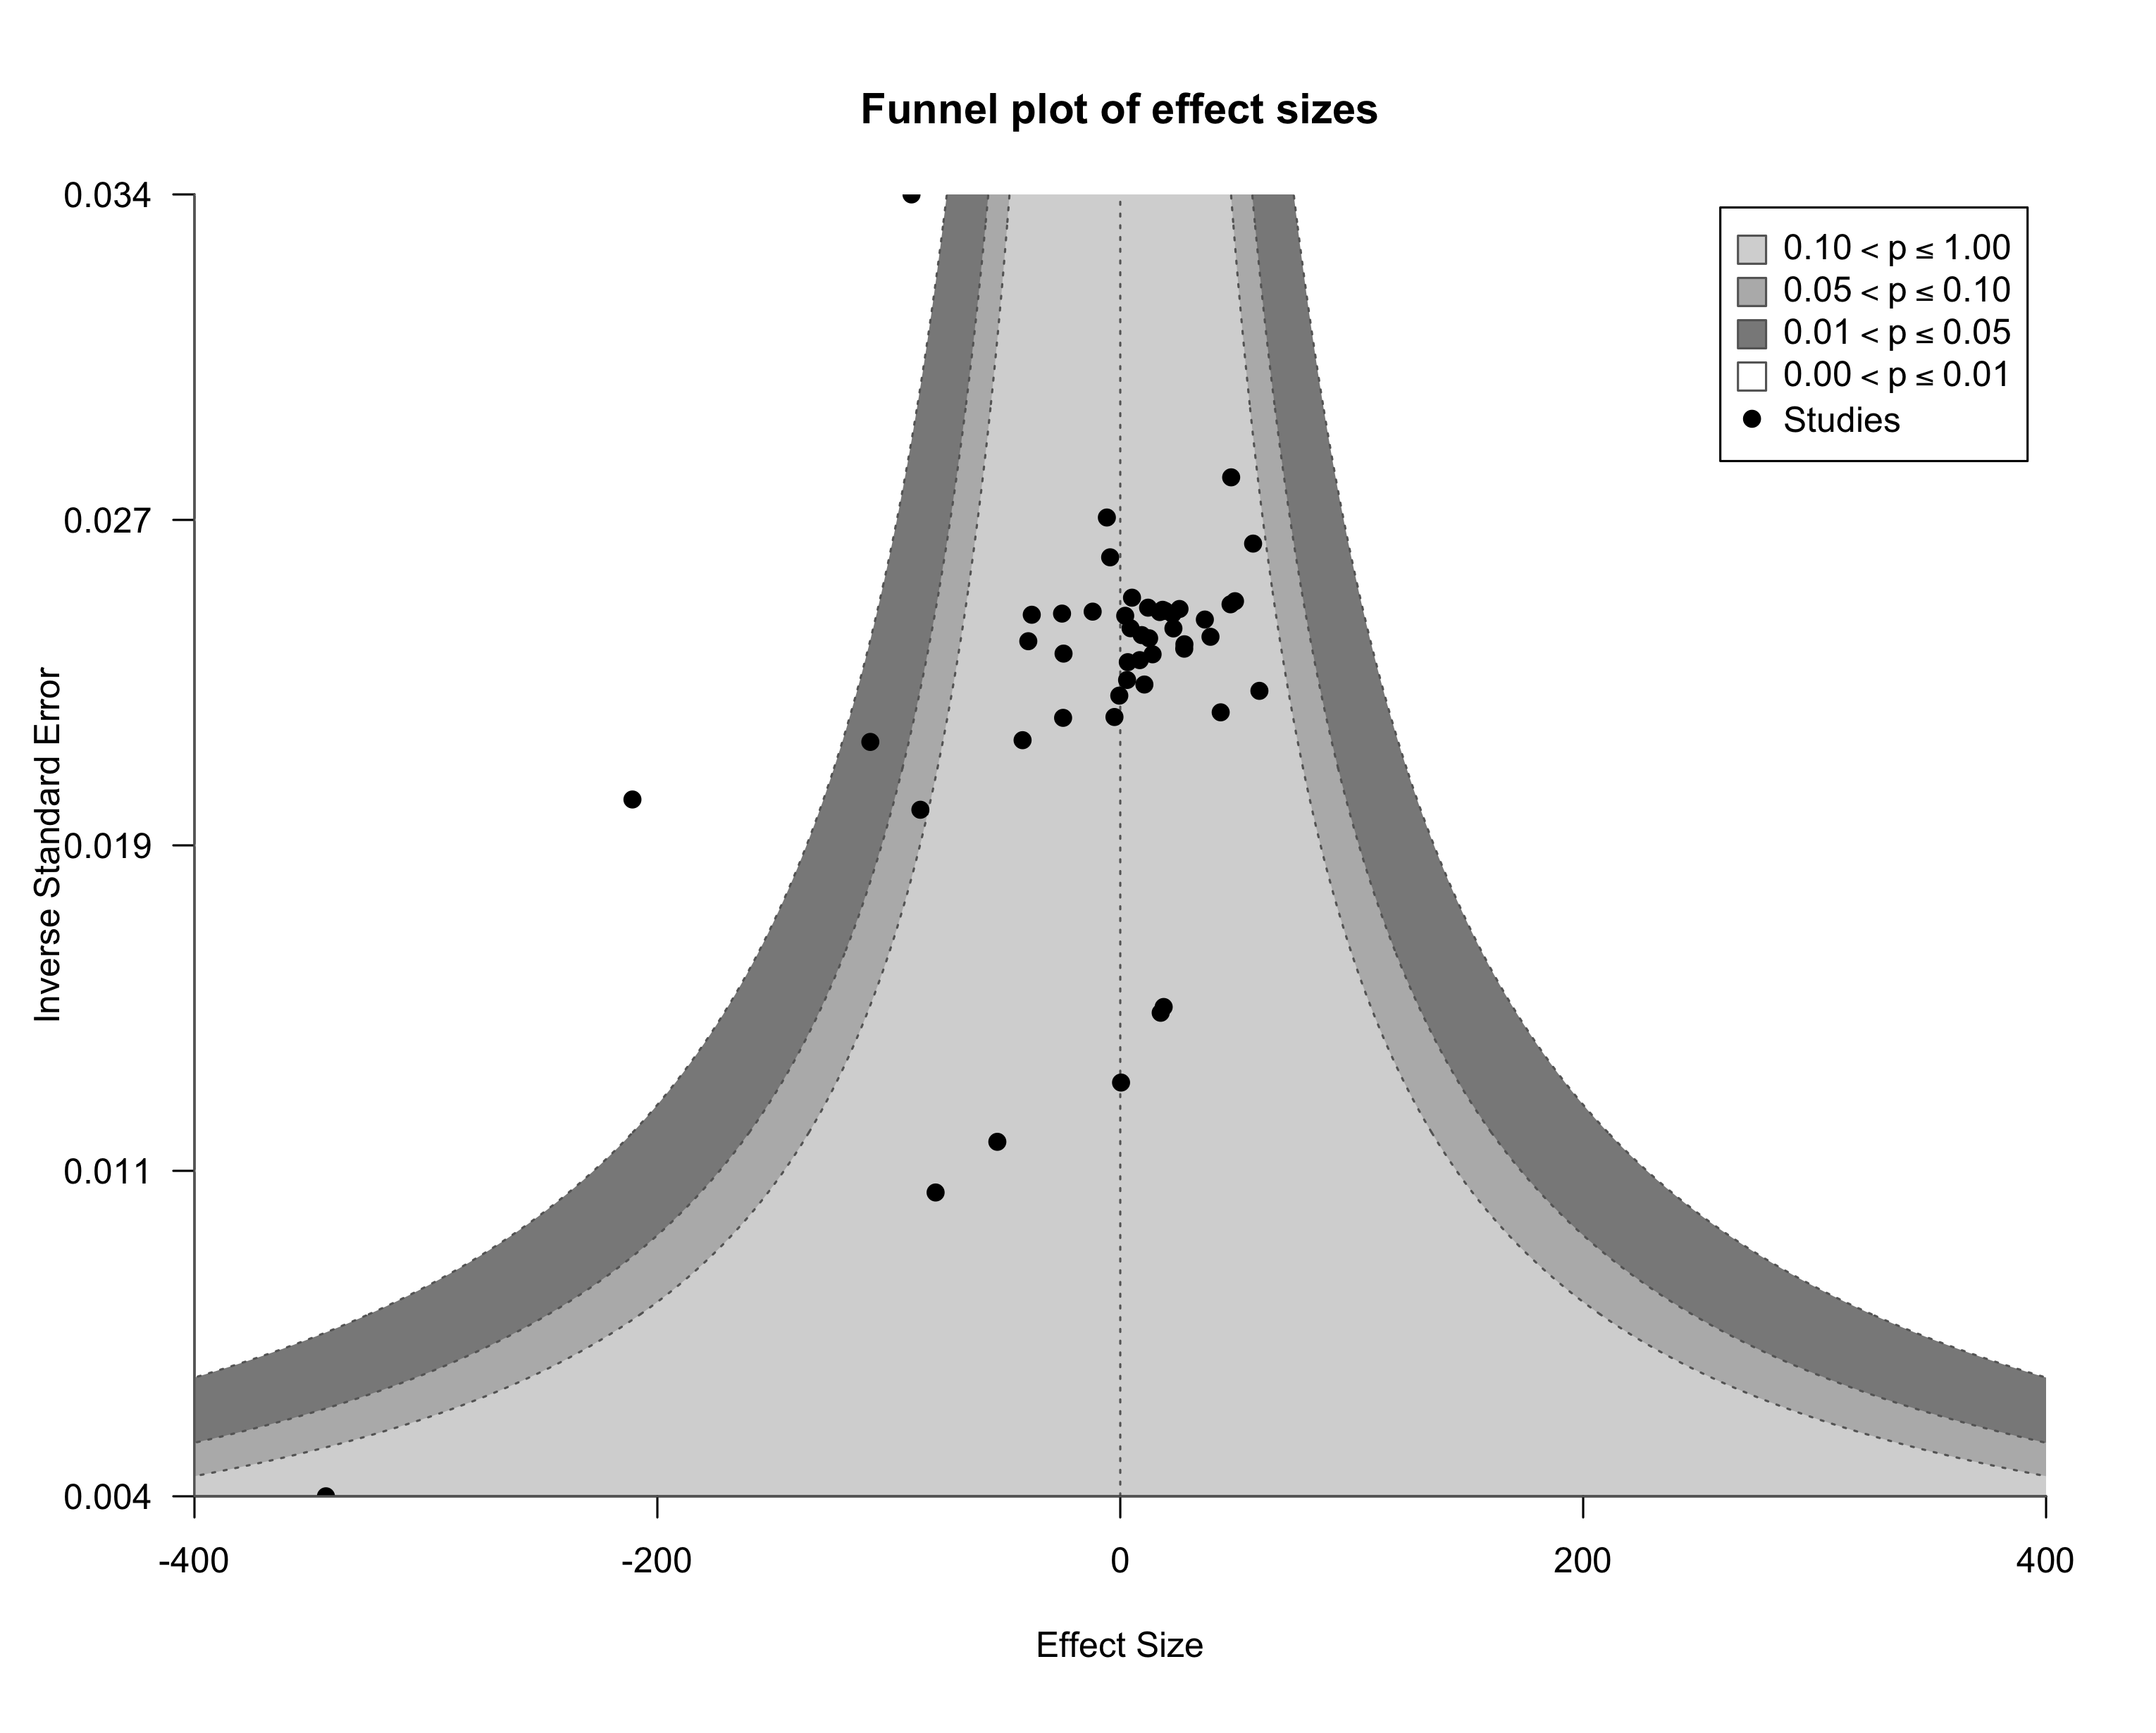

In [61]:
### FUNNEL PLOTTING FOR PUBLICATION BIAS
plotting.plot_funnel_from_model(
    interaction_model,
    main='Funnel plot of effect sizes',
    effect_type='Effect Size',
    shade_colors=['#d6d6d6', '#b8b8b8', '#8a8a8a'],
    back_color='white',
    level=[0.1, 0.05, 0.01],
    legend=True,
    hlines=[0],
    yaxis='seinv',
    digits=[1, 3],
    las=1,
    xaxs='i',
    yaxs='i',
    xlim=[-max(abs(interaction_df[effect_type].min()), abs(interaction_df[effect_type].max())), max(abs(interaction_df[effect_type].min()), abs(interaction_df[effect_type].max()))],
    ylim=[0,4],
    plot_in_python=True,
    figsize=(10, 8),
    save_path = config.fig_dir / 'bioerosion_funnel_plot.png'
)

## Investigating groupings

In [62]:
### create a dataframe for each grouping
community_effects_df = working_effects_df[working_effects_df.core_grouping == 'community']
sponge_effects_df = working_effects_df[working_effects_df.core_grouping == 'sponge']
microerosion_effects_df = working_effects_df[working_effects_df.core_grouping == 'microerosion']

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Redundant predictors dropped from the model. 




----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  6
Total samples of relevant investigation:  6
Dropped due to NaN values in required columns: 0
Final sample count: 6 (0 rows dropped)

Removed 1 outlier(s) (from 6 samples) based on Cook's distance threshold of 1.41
Using formula st_relative_calcification ~ delta_ph * delta_t

Running metafor model...
Model fitting complete.


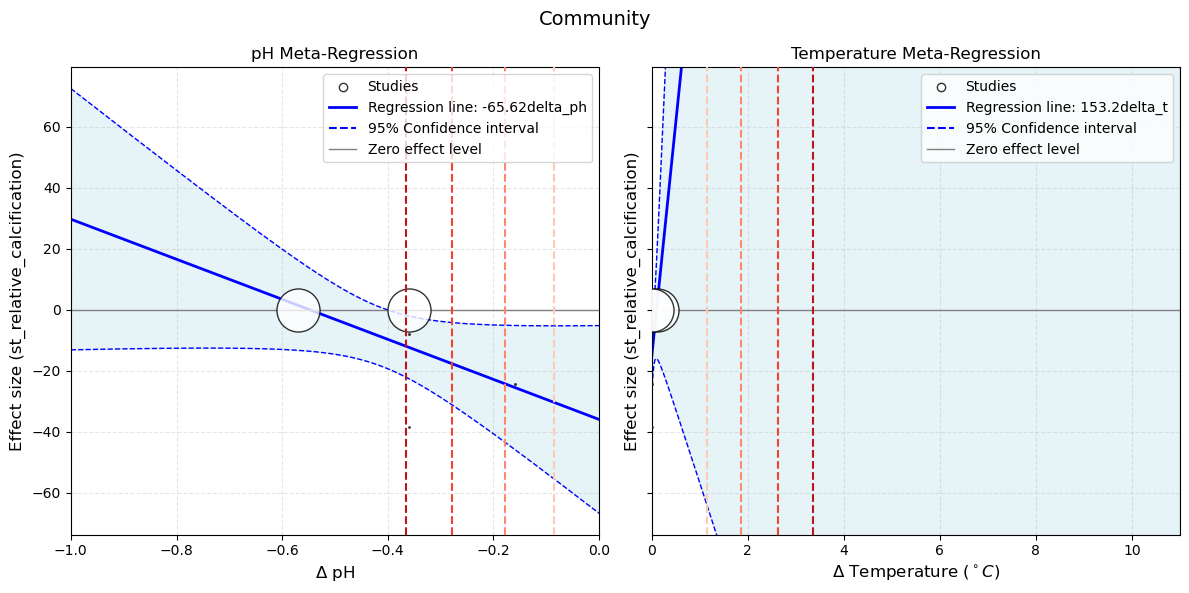

In [63]:
### COMMUNITY
community_model, community_model_summary, community_model_formula, _ = analysis.run_metafor_mv(
    community_effects_df,
    effect_type=effect_type,
    treatment=['phtot', 'temp', 'phtot_temp_mv'],
    formula=f"{effect_type} ~ delta_ph * delta_t"
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

var = 'phtot'   # Plot the pH meta-regression
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, ph_reg_ax = plotting.meta_regplot(
    model=community_model,
    model_comps = analysis.get_formula_components(community_model_formula),
    x_mod = 'delta_ph',
    pi=False,
    xlab=xlab,
    predlim=xlim,
    xlim=xlim,
    ax=axes[0],
    future_global_anomaly_df=future_global_anomaly_df,
    scenario_var=scenario_var,
)
axes[0].set_title("pH Meta-Regression")
plotting.add_climatology_lines_to_plot(ph_reg_ax, future_global_anomaly_df, scenario_var, xlim)


var = 'temp'    # Plot the temperature meta-regression
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, temp_reg_ax = plotting.meta_regplot(
    model=community_model,
    model_comps = analysis.get_formula_components(community_model_formula),
    x_mod = 'delta_t',
    pi=False,
    xlab=xlab,
    predlim=xlim,
    xlim=xlim,
    ax=axes[1],
)
plotting.add_climatology_lines_to_plot(temp_reg_ax, future_global_anomaly_df, scenario_var, xlim)
axes[1].set_title("Temperature Meta-Regression")

plt.suptitle('Community', fontsize=14)
plt.tight_layout()
plt.show()

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Redundant predictors dropped from the model. 

R[write to console]: 2: Extra argument ('useS4') disregarded. 




----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  7
Total samples of relevant investigation:  6
Dropped due to NaN values in required columns: 0
Final sample count: 6 (1 rows dropped)

Removed 1 outlier(s) (from 6 samples) based on Cook's distance threshold of 1.41
Using formula st_relative_calcification ~ delta_ph * delta_t

Running metafor model...
Model fitting complete.

Multivariate Meta-Analysis Model (k = 5; method: REML)

  logLik  Deviance       AIC       BIC      AICc   
 -8.7122   17.4243   27.4243   20.8901   87.4243   

Variance Components:

            estim    sqrt  nlvls  fixed           factor 
sigma^2.1  0.0010  0.0316      2     no     original_doi 
sigma^2.2  0.0010  0.0316      5     no  original_doi/ID 

Test for Residual Heterogeneity:
QE(df = 2) = 1.9478, p-val = 0.3776

Test of Moderators (coefficients 2:3):
QM(df = 2) = 3.6417, p-val = 0.1619

Model Results:

           estimate         se    zval    p

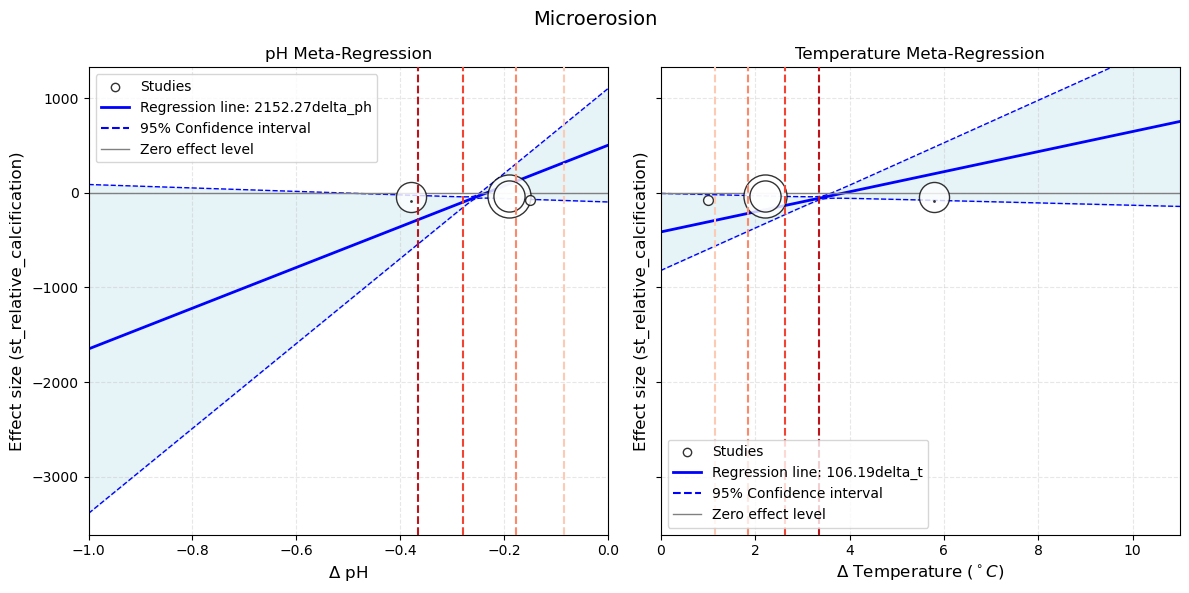

In [64]:
### MICROEROSION
microerosion_model, microerosion_model_summary, microerosion_model_formula, _ = analysis.run_metafor_mv(
    microerosion_effects_df,
    effect_type=effect_type,
    treatment=['phtot', 'temp', 'phtot_temp_mv'],
    formula=f"{effect_type} ~ delta_ph * delta_t"
)
print(microerosion_model_summary)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

var = 'phtot'   # Plot the pH meta-regression
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, ph_reg_ax = plotting.meta_regplot(
    model=microerosion_model,
    model_comps = analysis.get_formula_components(microerosion_model_formula),
    x_mod = 'delta_ph',
    pi=False,
    xlab=xlab,
    predlim=xlim,
    xlim=xlim,
    ax=axes[0],
    future_global_anomaly_df=future_global_anomaly_df,
    scenario_var=scenario_var,
)
axes[0].set_title("pH Meta-Regression")
plotting.add_climatology_lines_to_plot(ph_reg_ax, future_global_anomaly_df, scenario_var, xlim)


var = 'temp'    # Plot the temperature meta-regression
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, temp_reg_ax = plotting.meta_regplot(
    model=microerosion_model,
    model_comps = analysis.get_formula_components(microerosion_model_formula),
    x_mod = 'delta_t',
    pi=False,
    xlab=xlab,
    predlim=xlim,
    xlim=xlim,
    ax=axes[1],
)
plotting.add_climatology_lines_to_plot(temp_reg_ax, future_global_anomaly_df, scenario_var, xlim)
axes[1].set_title("Temperature Meta-Regression")

plt.suptitle('Microerosion', fontsize=14)
plt.tight_layout()
plt.show()


----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'phtot_temp_mv']
Total samples in input data:  55
Total samples of relevant investigation:  39
Dropped due to NaN values in required columns: 0
Final sample count: 39 (16 rows dropped)

Removed 2 outlier(s) (from 39 samples) based on Cook's distance threshold of 0.46
Using formula st_relative_calcification ~ delta_ph * delta_t

Running metafor model...
Model fitting complete.


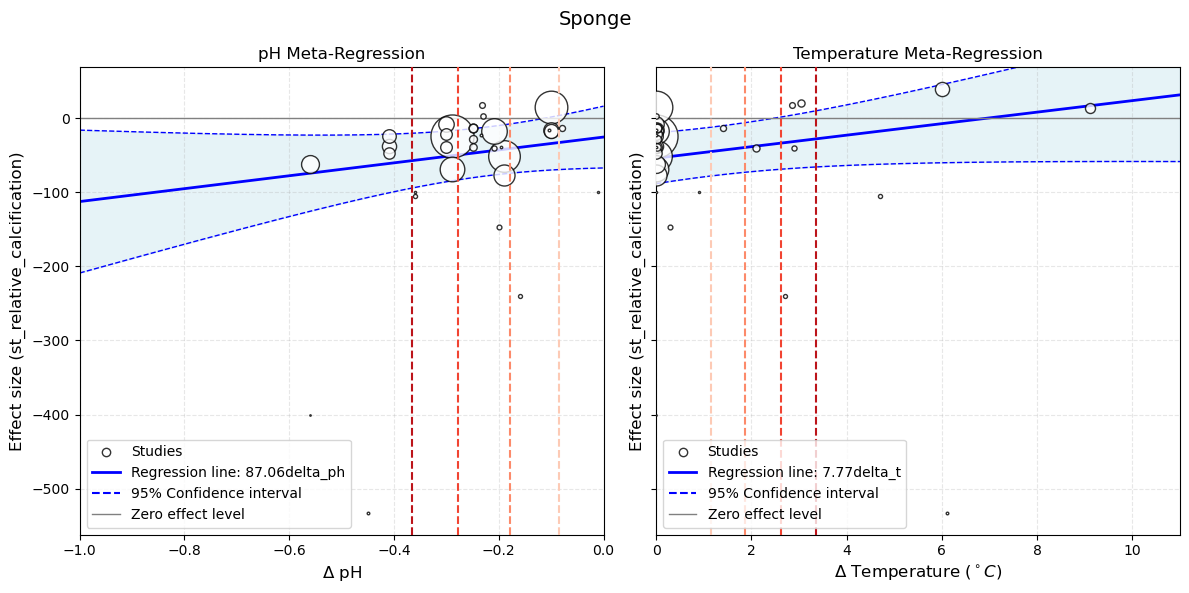

In [65]:
### SPONGE
sponge_model, sponge_model_summary, sponge_model_formula, _ = analysis.run_metafor_mv(
    sponge_effects_df,
    effect_type=effect_type,
    treatment=['phtot', 'temp', 'phtot_temp_mv'],
    formula=f"{effect_type} ~ delta_ph * delta_t"
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

var = 'phtot'   # Plot the pH meta-regression
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, ph_reg_ax = plotting.meta_regplot(
    model=sponge_model,
    model_comps = analysis.get_formula_components(sponge_model_formula),
    x_mod = 'delta_ph',
    pi=False,
    xlab=xlab,
    predlim=xlim,
    xlim=xlim,
    ax=axes[0],
    future_global_anomaly_df=future_global_anomaly_df,
    scenario_var=scenario_var,
)
axes[0].set_title("pH Meta-Regression")
plotting.add_climatology_lines_to_plot(ph_reg_ax, future_global_anomaly_df, scenario_var, xlim)


var = 'temp'    # Plot the temperature meta-regression
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, temp_reg_ax = plotting.meta_regplot(
    model=sponge_model,
    model_comps = analysis.get_formula_components(sponge_model_formula),
    x_mod = 'delta_t',
    pi=False,
    xlab=xlab,
    predlim=xlim,
    xlim=xlim,
    ax=axes[1],
)
plotting.add_climatology_lines_to_plot(temp_reg_ax, future_global_anomaly_df, scenario_var, xlim)
axes[1].set_title("Temperature Meta-Regression")

plt.suptitle('Sponge', fontsize=14)
plt.tight_layout()
plt.show()

# Predictions on future climatology

Generating predictions for combined `core_groupings` since individual sample sizes so small. Individual

In [66]:
### combine anomalies into a nice dataframe

ph_anomalies = processing.generate_location_specific_climatology_anomalies(working_clim_df, 'ph')
sst_anomalies = processing.generate_location_specific_climatology_anomalies(working_clim_df, 'sst')
merged_anomalies = pd.merge(ph_anomalies, sst_anomalies, on=['doi', 'location', 'longitude', 'latitude', 'scenario', 'time_frame', 'percentile'], suffixes=('_ph', '_sst')).drop(columns=['scenario_var_ph', 'scenario_var_sst'])
clim_df = merged_anomalies.groupby(['scenario', 'time_frame', 'percentile'])[['anomaly_value_ph', 'anomaly_value_sst']].mean().reset_index()    # average spatially

Generating batched anomalies for ph:   0%|          | 0/16 [00:00<?, ?it/s]

Generating batched anomalies for sst:   0%|          | 0/16 [00:00<?, ?it/s]

(<Figure size 1000x1000 with 4 Axes>,
 array([<Axes: ylabel='Relative calcification rate'>,
        <Axes: ylabel='Relative calcification rate'>,
        <Axes: ylabel='Relative calcification rate'>,
        <Axes: xlabel='Year', ylabel='Relative calcification rate'>],
       dtype=object))

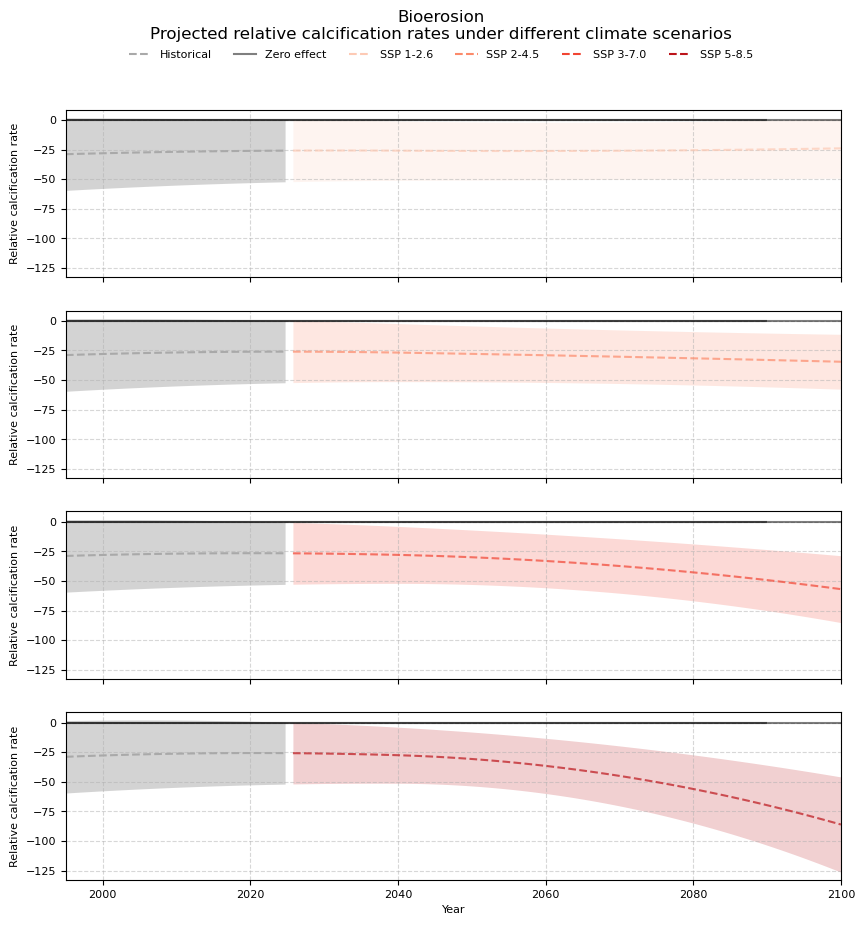

In [67]:
### prediction via interactive effect with core groupings   # TODO: this should take into account core_groupings
newmods = pd.DataFrame({
    'const': [1] * len(clim_df),
    'delta_ph': clim_df.anomaly_value_ph,
    'delta_t': clim_df.anomaly_value_sst,
    'delta_ph:delta_t': clim_df.anomaly_value_ph * clim_df.anomaly_value_sst,
})
predictions_df = analysis.predict_metafor_model_on_moderator_values(interaction_model, newmods)
predictions_bioerosion_df = pd.concat([clim_df, predictions_df], axis=1)
plotting.plot_global_timeseries(predictions_bioerosion_df, title_org="Bioerosion", figsize=(10, 10), dpi=300)

In [69]:
### save predictions to csv for combination with other predictions
predictions_bioerosion_df.loc[:, 'core_grouping'] = 'Bioerosion'
predictions_bioerosion_df.to_csv(config.tmp_data_dir / 'bioerosion_predictions.csv', index=False)